In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import seaborn as sns
from datetime import datetime,date,time, timedelta
from pathlib import Path


In [266]:
data_df=pd.read_csv(str(Path.home())+"/Desktop/Corona/data/countries_regions.csv")

In [267]:
#data_df=data_df.dropna()
data_df=data_df.loc[data_df.datasource=="ECDC"]

In [268]:


countries=data_df.country.drop_duplicates()
data_df.date=data_df.apply(lambda x:datetime.strptime(x.date,"%Y-%m-%d"), axis=1)
#data=data.loc[data.date>datetime.strptime("2020-02-01","%Y-%m-%d")]
#countries

In [269]:

# Now we need to fix mobility before and after the first dates

mobilitycolumns=["retail_and_recreation","grocery_and_pharmacy","parks","transit_stations","workplaces","residential"]
R0columns=["R0"] #,"R0-FixSI"]

    
columns=["country","R0","new_confirmed_cases","new_deaths","date","deaths","confirmed","Ratio",
         "deaths_7days","cases_7days","popData2018","code","retail_and_recreation",
         "grocery_and_pharmacy","parks","transit_stations","workplaces","residential",
         "date_sec","deaths/million","cases/million","Current deaths/million",
         "Current cases/million","log_deaths","log_cases","log_deaths_7days","log_cases_7days",
         "log_deaths/million","log_cases/million","log_current_deaths/million",
         "log_current_cases/million","days_left","log_days_left"]

data_df.rename(columns={
    "deaths/million":"deaths_per_million",
    "cases/million":"cases_per_million",
    "Current deaths/million":"Current-deaths_per_million",
    "Current cases/million":"Current-cases_per_million",
    "log_deaths":"log_deaths",
    "log_deaths/million":"log_deaths_per_million",
    "log_cases/million":"log_cases_per_million",
    "log_current_deaths/million":"log_current_deaths_per_million",
    "log_current_cases/million":"log_current_cases_per_million",
 },inplace=True)


In [270]:

def plot_time_new(df,outname,name,columns): #x,end,start_dat,end_date,R,cases, lower_bound, higher_bound,lower_bound25, higher_bound75,ylabel,outname)
    '''Plot with shaded 95 % CI (plots both 1 and 2 std, where 2 = 95 % interval)
    '''
    #extra=["new_deaths","new_confirmed_cases"]
    extra=["R0"] #,"R0_7days"]
    #extra=[]
    fig, ax1 = plt.subplots(figsize=(16,10))
    #tmp_df=df.loc[df.date>=startdate]
    tmp_df=df.groupby(['date'])[columns+extra].mean()
    std_df=df.groupby(['date'])[columns+extra].std()
    N_df=df.groupby(['date'])[columns+extra].size()
    N_df=N_df.apply(lambda x: np.sqrt(x))
    stderr_df=pd.DataFrame([])
    lower_bound=pd.DataFrame([])
    higher_bound=pd.DataFrame([])
    lower_bound25=pd.DataFrame([])
    higher_bound75=pd.DataFrame([])

    for c in columns+extra:
        stderr_df[c]=std_df[c]/N_df
        higher_bound[c]=tmp_df[c]+1.96*stderr_df[c]
        lower_bound[c]=tmp_df[c]-1.96*stderr_df[c]
        higher_bound75[c]=tmp_df[c]+1.15*stderr_df[c]
        lower_bound25[c]=tmp_df[c]-1.15*stderr_df[c]


    tmp_df["date"]=df.groupby(['date'])["date"].first()
    #tmp_df=df
    #print (tmp_df)
    x=np.arange(0,len(tmp_df))
    #print (tmp_df)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #shift=-0.2
    #for c in extra:
    #    ax2.bar(x+shift,tmp_df[c],yerr=stderr_df[c], alpha = 0.5,width=0.4,label=c)
    #    shift+=0.4
    for c in extra:
        y=tmp_df[c]
        yerr=std_df[c]
        ax2.plot(x,y,label=c, linewidth = 1.0,color="g")
        ax2.fill_between(x, lower_bound[c], higher_bound[c], color='lightgreen', alpha=0.4)
        ax2.fill_between(x, lower_bound25[c], higher_bound75[c], color='lightgreen', alpha=0.6)
        
    ax2.set_ylabel('R0',color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend()
    for c in columns:
        y=tmp_df[c]
        yerr=std_df[c]
        ax1.plot(x,y,label=c, linewidth = 1.0)
        ax1.fill_between(x, lower_bound[c], higher_bound[c], color='cornflowerblue', alpha=0.4)
        ax1.fill_between(x, lower_bound25[c], higher_bound75[c], color='cornflowerblue', alpha=0.6)
    dates = tmp_df['date'].to_list()
    #ax1.legend(loc='lower left', frameon=False, markerscale=2)
    ax1.set_ylabel('Value')
    #ax1.set_yscale('log')
    ax1.set(title="R0 and mobility "+ name )
    ax1.grid(color='b',linestyle="-",linewidth=1)
    ax1.tick_params(axis='x', labelrotation=45 )    
    #ax1.set_ylim([0,max(higher_bound)])
    xticks=np.arange(0,len(tmp_df),7)
    #yticks=[0.1,0.5,1,2,5,10]
    
    #ax1.set_xticklabels(dates)
    #plt.xticks(rotation=45, ha='right')
    ax1.set_xticklabels(dates[0::7],rotation=45)
    #ax1.set_yticklabels(["0.1","0.5","1","2","5","10"])
    ax1.set_xticks(xticks)
    #ax1.set_yticks(yticks)
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.tight_layout()
    ax1.legend()
    #fig.savefig(outname, format = 'png', dpi=300)
    #plt.close(fig="all")


In [318]:

def plot_time_triplett(df,outname,name,columns,columns2): #x,end,start_dat,end_date,R,cases, lower_bound, higher_bound,lower_bound25, higher_bound75,ylabel,outname)
    '''Plot with shaded 95 % CI (plots both 1 and 2 std, where 2 = 95 % interval)
    '''
    #extra=["new_deaths","new_confirmed_cases"]
    extra=["R0_7days"]
    #extra=[]
    fig, ax1 = plt.subplots(figsize=(16,10))
    #tmp_df=df.loc[df.date>=startdate]
    tmp_df=df.groupby(['date'])[columns+extra+columns2].mean()
    std_df=df.groupby(['date'])[columns+extra+columns2].std()
    N_df=df.groupby(['date'])[columns+extra+columns2].size()
    N_df=N_df.apply(lambda x: np.sqrt(x))
    stderr_df=pd.DataFrame([])
    lower_bound=pd.DataFrame([])
    higher_bound=pd.DataFrame([])
    lower_bound25=pd.DataFrame([])
    higher_bound75=pd.DataFrame([])

    for c in columns+extra+columns2:
        stderr_df[c]=std_df[c]/N_df
        higher_bound[c]=tmp_df[c]+1.96*stderr_df[c]
        lower_bound[c]=tmp_df[c]-1.96*stderr_df[c]
        higher_bound75[c]=tmp_df[c]+1.15*stderr_df[c]
        lower_bound25[c]=tmp_df[c]-1.15*stderr_df[c]


    tmp_df["date"]=df.groupby(['date'])["date"].first()
    #tmp_df=df
    #print (tmp_df)
    x=np.arange(0,len(tmp_df))
    #print (tmp_df)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #shift=-0.2
    #for c in extra:
    #    ax2.bar(x+shift,tmp_df[c],yerr=stderr_df[c], alpha = 0.5,width=0.4,label=c)
    #    shift+=0.4
    for c in extra:
        y=tmp_df[c]
        yerr=std_df[c]
        ax2.plot(x,y,label=c, linewidth = 1.0,color="g")
        ax2.fill_between(x, lower_bound[c], higher_bound[c], color='lightgreen', alpha=0.4)
        ax2.fill_between(x, lower_bound25[c], higher_bound75[c], color='lightgreen', alpha=0.6)        
    ax2.set_ylabel('R0',color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend()
    
    for c in columns2:
        y=tmp_df[c]
        yerr=std_df[c]
        ax3.plot(x,y,label=c, linewidth = 4.0)
        ax3.fill_between(x, lower_bound[c], higher_bound[c], color='pink', alpha=0.4)
        ax3.fill_between(x, lower_bound25[c], higher_bound75[c], color='pink', alpha=0.6)        
    ax3.set_ylabel('mobility',color='r')
    ax3.tick_params(axis='y', labelcolor='r')
    ax3.legend()
    
     
    
    for c in columns:
        y=tmp_df[c]
        yerr=std_df[c]
        ax1.plot(x,y,label=c, linewidth = 4.0)
        ax1.fill_between(x, lower_bound[c], higher_bound[c], color='cornflowerblue', alpha=0.4)
        ax1.fill_between(x, lower_bound25[c], higher_bound75[c], color='cornflowerblue', alpha=0.6)
    dates = tmp_df['date'].to_list()
    #ax1.legend(loc='lower left', frameon=False, markerscale=2)
    ax1.set_ylabel('Value')
    #ax1.set_yscale('log')
    ax1.set(title="R0 and mobility "+ name )
    ax1.grid(color='b',linestyle="-",linewidth=1)
    ax1.tick_params(axis='x', labelrotation=45 )    
    #ax1.set_ylim([0,max(higher_bound)])
    xticks=np.arange(0,len(tmp_df),7)
    #yticks=[0.1,0.5,1,2,5,10]
    
    #ax1.set_xticklabels(dates)
    #plt.xticks(rotation=45, ha='right')
    ax1.set_xticklabels(dates[0::7],rotation=45)
    #ax1.set_yticklabels(["0.1","0.5","1","2","5","10"])
    ax1.set_xticks(xticks)
    #ax1.set_yticks(yticks)
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.tight_layout()
    ax1.legend()
    #fig.savefig(outname, format = 'png', dpi=300)
    #plt.close(fig="all")


In [316]:

def plot_date(df,outname,name,columns): #x,end,start_dat,end_date,R,cases, lower_bound, higher_bound,lower_bound25, higher_bound75,ylabel,outname)
    '''Plot with shaded 95 % CI (plotsext both 1 and 2 std, where 2 = 95 % interval)
    '''
    #extra=["new_deaths","new_confirmed_cases"]
    extra=["R0"] #,"R0_7days"]
    #extra=[]
    fig, ax1 = plt.subplots(figsize=(16,10))
    #tmp_df=df.loc[df.date>=startdate]
    tmp_df=df.groupby(['date'])[columns+extra].mean()
    std_df=df.groupby(['date'])[columns+extra].std()
    N_df=df.groupby(['date'])[columns+extra].size()
    N_df=N_df.apply(lambda x: np.sqrt(x))
    stderr_df=pd.DataFrame([])
    lower_bound=pd.DataFrame([])
    higher_bound=pd.DataFrame([])
    lower_bound25=pd.DataFrame([])
    higher_bound75=pd.DataFrame([])

    for c in columns+extra:
        stderr_df[c]=std_df[c]/N_df
        higher_bound[c]=tmp_df[c]+1.96*stderr_df[c]
        lower_bound[c]=tmp_df[c]-1.96*stderr_df[c]
        higher_bound75[c]=tmp_df[c]+1.15*stderr_df[c]
        lower_bound25[c]=tmp_df[c]-1.15*stderr_df[c]


    tmp_df["date"]=df.groupby(['date'])["date"].first()
    #tmp_df=df
    #print (tmp_df)
    x=np.arange(0,len(tmp_df))
    #print (tmp_df)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #shift=-0.2
    #for c in extra:
    #    ax2.bar(x+shift,tmp_df[c],yerr=stderr_df[c], alpha = 0.5,width=0.4,label=c)
    #    shift+=0.4
    for c in extra:
        y=tmp_df[c]
        yerr=std_df[c]
        ax2.plot(x,y,label=c, linewidth = 1.0,color="g")
        ax2.fill_between(x, lower_bound[c], higher_bound[c], color='lightgreen', alpha=0.4)
        ax2.fill_between(x, lower_bound25[c], higher_bound75[c], color='lightgreen', alpha=0.6)
        
    ax2.set_ylabel('R0',color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend()
    for c in columns:
        y=tmp_df[c]
        yerr=std_df[c]
        ax1.plot(x,y,label=c, linewidth = 1.0)
        ax1.fill_between(x, lower_bound[c], higher_bound[c], color='cornflowerblue', alpha=0.4)
        ax1.fill_between(x, lower_bound25[c], higher_bound75[c], color='cornflowerblue', alpha=0.6)
    dates = tmp_df['date'].to_list()
    #ax1.legend(loc='lower left', frameon=False, markerscale=2)
    ax1.set_ylabel('Value')
    #ax1.set_yscale('log')
    ax1.set(title="R0 and mobility "+ name )
    ax1.grid(color='b',linestyle="-",linewidth=1)
    ax1.tick_params(axis='x', labelrotation=45 )    
    #ax1.set_ylim([0,max(higher_bound)])
    xticks=np.arange(0,len(tmp_df),7)
    #yticks=[0.1,0.5,1,2,5,10]
    
    #ax1.set_xticklabels(dates)
    #plt.xticks(rotation=45, ha='right')
    ax1.set_xticklabels(dates[0::7],rotation=45)
    #ax1.set_yticklabels(["0.1","0.5","1","2","5","10"])
    ax1.set_xticks(xticks)
    #ax1.set_yticks(yticks)
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.tight_layout()
    ax1.legend()
    #fig.savefig(outname, format = 'png', dpi=300)
    #plt.close(fig="all")


In [272]:
#data_df=backup
backup=data_df
data_df

Unnamed: 0  index      country        R0      sdR0  R0-FixSI  \
17138       17138      0  Afghanistan  5.006418  4.997506  5.000000   
17139       17139      1  Afghanistan  4.998323  4.995612  5.000000   
17140       17140      2  Afghanistan  4.989282  4.985760  5.000000   
17141       17141      3  Afghanistan  5.001742  4.999842  5.000000   
17142       17142      4  Afghanistan  5.001094  5.006346  5.000000   
...           ...    ...          ...       ...       ...       ...   
46021       46021  28883     Zimbabwe  1.000000       NaN       NaN   
46022       46022  28884     Zimbabwe  1.000000       NaN       NaN   
46023       46023  28885     Zimbabwe  1.690815  1.385476  2.687142   
46024       46024  28886     Zimbabwe  1.690815  1.385476  2.687142   
46025       46025  28887     Zimbabwe  1.690815  1.385476  2.687142   

       sdR0-FixSI  new_confirmed_cases  new_deaths       date  ...  \
17138    5.000000                  0.0         0.0 2020-01-04  ...   
17139    5.000000                  0.0         0.0 2020-01-05  ...   
17140    5.000000                  0.0         0.0 2020-01-06  ...   
17141    5.000000                  0.0         0.0 2020-01-07  ...   
17142    5.000000                  0.0         0.0 2020-01-08  ...   
...           ...                  ...         ...        ...  ...   
46021         NaN                  2.0         0.0 2020-05-21  ...   
46022         NaN                  3.0         0.0 2020-05-22  ...   
46023    0.826478                  5.0         0.0 2020-05-23  ...   
46024    0.826478                  0.0         0.0 2020-05-24  ...   
46025    0.826478                  0.0         0.0 2020-05-25  ...   

       deaths_slope  retail_and_recreation_7days  grocery_and_pharmacy_7days  \
17138           0.0                     0.000000                    0.000000   
17139           0.0                     0.000000                    0.000000   
17140           0.0                     0.000000                    0.000000   
17141           0.0                     0.000000                    0.000000   
17142           0.0                     0.000000                    0.000000   
...             ...                          ...                         ...   
46021           0.0                   -34.964286                  -22.660714   
46022           0.0                   -35.357143                  -23.107143   
46023           0.0                   -35.750000                  -24.125000   
46024           0.0                   -35.750000                  -24.125000   
46025           0.0                   -35.750000                  -24.125000   

       parks_7days  transit_stations_7days  workplaces_7days  \
17138     0.000000                0.000000          0.000000   
17139     0.000000                0.000000          0.000000   
17140     0.000000                0.000000          0.000000   
17141     0.000000                0.000000          0.000000   
17142     0.000000                0.000000          0.000000   
...            ...                     ...               ...   
46021   -27.660714              -52.946429        -24.178571   
46022   -27.821429              -53.392857        -23.928571   
46023   -28.125000              -54.125000        -25.250000   
46024   -28.125000              -54.125000        -25.250000   
46025   -28.125000              -54.125000        -25.250000   

      residential_7days  R0_7days  R0-FixSI_7days  confirmed_7days  
17138          0.000000  4.999175             5.0         0.000000  
17139          0.000000  4.999175             5.0         0.000000  
17140          0.000000  4.999175             5.0         0.000000  
17141          0.000000  4.999175             5.0         0.000000  
17142          0.000000  4.999175             5.0         0.000000  
...                 ...       ...             ...              ...  
46021         26.535714  1.690815             NaN        44.142857  
46022         26.214286  1.2778

In [273]:
merged_df=data_df

In [274]:
d=merged_df["deaths_ratio"].idxmin()
print (d)
print(merged_df["country"][d])
print(merged_df["date"][d])
print(merged_df["country"][d-7])
print(merged_df["date"][d-7])
print(merged_df["deaths"][d])
print(merged_df["deaths_diff7"][d])
print(merged_df["deaths"][d-7:d])
print(merged_df["deaths_ratio"][d])
print(merged_df["confirmed"][d])


28442
Guinea
2020-01-09 00:00:00
Guinea
2020-05-24 00:00:00
0.0
-20.0
45573    0.0
45574    0.0
45575    0.0
45576    0.0
45577    0.0
45578    0.0
45579    0.0
Name: deaths, dtype: float64
-99999.0
0.0


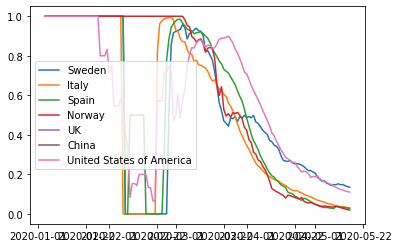

In [275]:
merged_df=merged_df.dropna()
#merged_df=merged_df.loc[merged_df.deaths>0]
for c in ["Sweden","Italy","Spain","Norway","UK","China","United States of America"]:
    country_df=merged_df.loc[merged_df.country==c] # ,"confirmed-ratio"]
    plt.plot(country_df["date"],country_df["confirmed_ratio"],label=c)
    plt.legend()

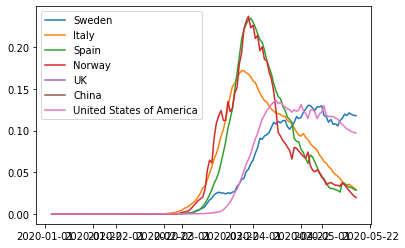

In [276]:
merged_df=merged_df.dropna()
#merged_df=merged_df.loc[merged_df.deaths>0]
for c in ["Sweden","Italy","Spain","Norway","UK","China","United States of America"]:
    country_df=merged_df.loc[merged_df.country==c] # ,"confirmed-ratio"]
    plt.plot(country_df["date"],country_df["confirmed_slope"],label=c)
    plt.legend()

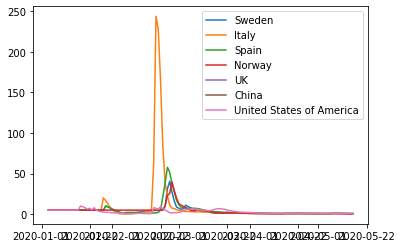

In [277]:
merged_df=merged_df.dropna()
#merged_df=merged_df.loc[merged_df.deaths>0]
for c in ["Sweden","Italy","Spain","Norway","UK","China","United States of America"]:
    country_df=merged_df.loc[merged_df.country==c] # ,"confirmed-ratio"]
    plt.plot(country_df["date"],country_df["R0"],label=c)
    plt.legend()

In [320]:
mobilitycolumns7=["retail_and_recreation_7days","grocery_and_pharmacy_7days","parks_7days",
                 "transit_stations_7days","workplaces_7days","residential_7days"]

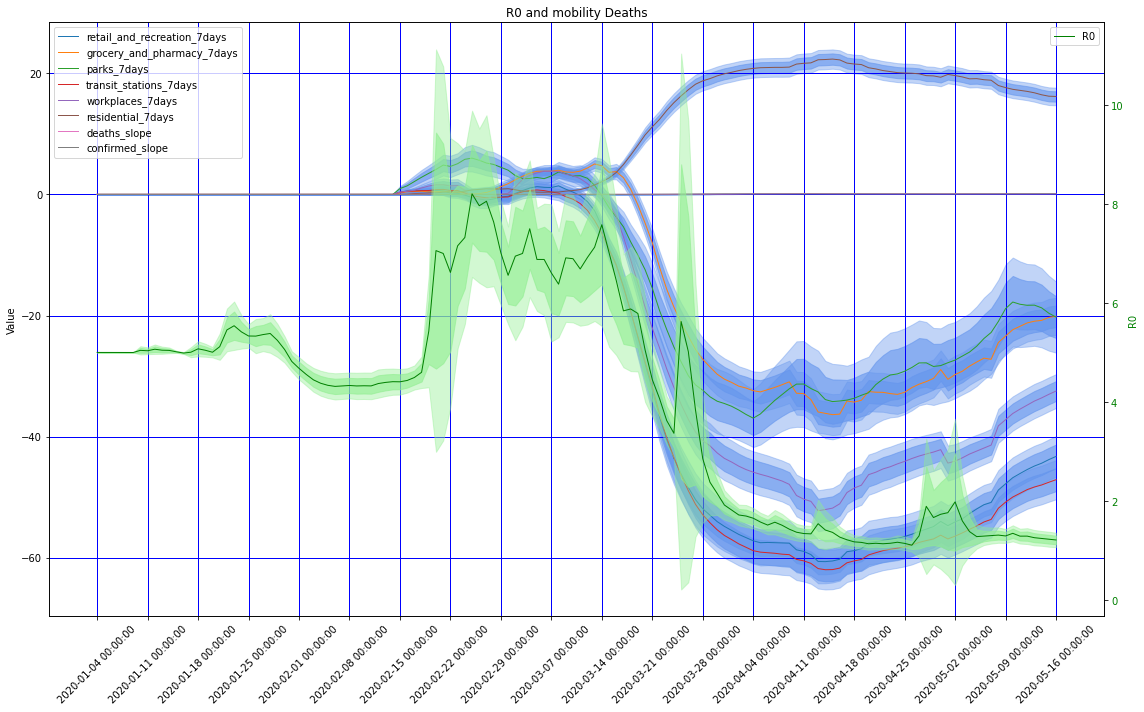

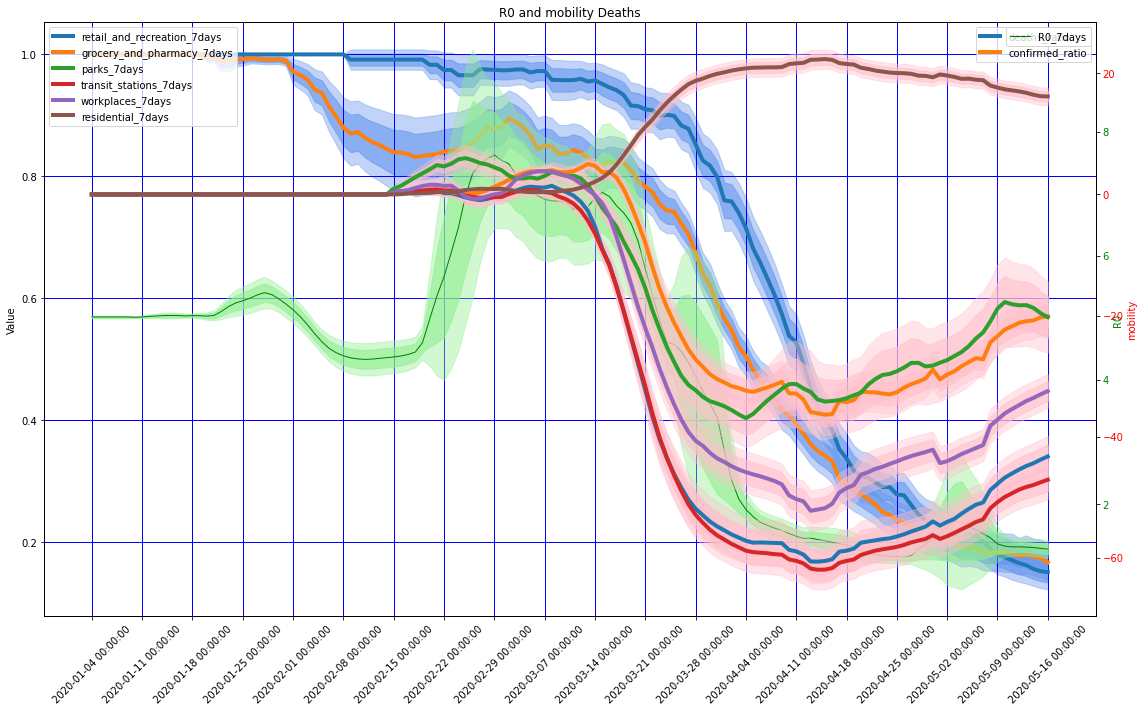

In [322]:
plot_time_new(merged_df,"foo.png","Deaths",mobilitycolumns7+["deaths_slope","confirmed_slope"])
plot_time_triplett(merged_df,"foo.png","Deaths",["deaths_ratio","confirmed_ratio"],mobilitycolumns7)

In [279]:
#values=pd.DataFrame([])
#for country in countries:
#    for key in merged_df.columns:

last_df=merged_df.loc[merged_df.date==datetime.strptime("2020-05-14","%Y-%m-%d")]

    
    

In [280]:
last_df

Unnamed: 0  index              country        R0      sdR0  R0-FixSI  \
17269       17269    131          Afghanistan  1.462970  0.106182  1.373824   
17841       17841    703               Angola  0.617774  0.255685  0.605193   
17984       17984    846  Antigua and Barbuda  2.569134  2.771929  3.673661   
18127       18127    989            Argentina  1.687994  0.193708  1.478744   
18413       18413   1275                Aruba  1.109766  1.194544  1.182273   
...           ...    ...                  ...       ...       ...       ...   
45156       45156  28018              Uruguay  0.666461  0.120283  0.671345   
45442       45442  28304            Venezuela  1.859418  0.220662  1.732039   
45728       45728  28590                Yemen  2.640320  0.561723  2.135207   
45871       45871  28733               Zambia  2.786835  0.964866  1.788434   
46014       46014  28876             Zimbabwe  3.751248  1.555385  3.192652   

       sdR0-FixSI  new_confirmed_cases  new_deaths       date  ...  \
17269    0.028220                259.0         3.0 2020-05-14  ...   
17841    0.247069                  0.0         0.0 2020-05-14  ...   
17984    3.673661                  0.0         0.0 2020-05-14  ...   
18127    0.032820                316.0        10.0 2020-05-14  ...   
18413    1.182273                  0.0         0.0 2020-05-14  ...   
...           ...                  ...         ...        ...  ...   
45156    0.118678                  2.0         0.0 2020-05-14  ...   
45442    0.170663                 17.0         0.0 2020-05-14  ...   
45728    0.223831                  3.0         1.0 2020-05-14  ...   
45871    0.086447                  5.0         0.0 2020-05-14  ...   
46014    1.064217                  0.0         0.0 2020-05-14  ...   

       deaths_slope  retail_and_recreation_7days  grocery_and_pharmacy_7days  \
17269      0.119266                   -38.571429                  -14.285714   
17841      0.000000                   -37.428571                  -19.285714   
17984      0.000000                   -40.428571                  -26.571429   
18127      0.123894                   -72.857143                  -24.142857   
18413      0.333333                   -50.857143                  -17.285714   
...             ...                          ...                         ...   
45156      0.090909                   -39.142857                  -18.571429   
45442      0.000000                   -49.428571                  -30.000000   
45728      0.166667                    -5.285714                    3.714286   
45871      0.428571                   -13.428571                   -4.571429   
46014      0.000000                   -36.857143                  -25.714286   

       parks_7days  transit_stations_7days  workplaces_7days  \
17269   -19.285714              -42.571429        -26.571429   
17841   -24.285714              -49.571429        -21.000000   
17984   -27.142857              -62.000000        -46.142857   
18127   -89.142857              -54.285714        -35.142857   
18413   -28.571429              -55.285714        -43.000000   
...            ...                     ...               ...   
45156   -54.000000              -39.714286        -19.000000   
45442   -43.714286              -50.571429        -31.285714   
45728    -8.857143               -4.142857         -8.000000   
45871     0.000000              -15.857143         -5.285714   
46014   -29.571429              -56.000000        -27.428571   

      residential_7days  R0_7days  R0-FixSI_7days  confirmed_7days  
17269         12.428571  1.410599        1.294115      4379.428571  
17841         19.714286  1.060136        0.976569        43.142857  
17984          0.375000  1.634500        2.134839        25.000000  
18127         20.000000  1.503384        1.421147      5990.285714  
18413         17.000000  1.787145        1.533857       101.000000  
...                 ...       ...             ...              ...  
4515

In [281]:
last_df.parks


17269   -16.0
17841   -17.0
17984   -23.0
18127   -88.0
18413   -32.0
         ... 
45156   -54.0
45442   -45.0
45728    -8.0
45871     4.0
46014   -29.0
Name: parks, Length: 117, dtype: float64

In [285]:
mobilitycolumns=["retail_and_recreation","grocery_and_pharmacy","parks",
                 "transit_stations","workplaces","residential"]


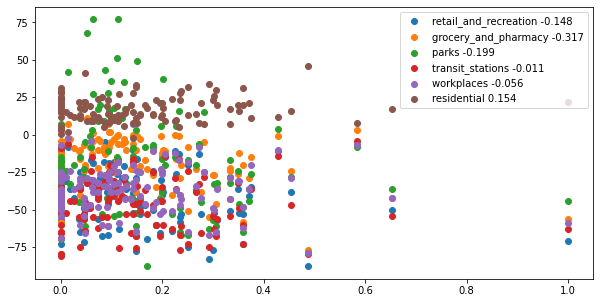

In [309]:
corr={}
fig, ax=plt.subplots(figsize=(10,5))

for col in mobilitycolumns:
    corr[col]=np.corrcoef(last_df.deaths_ratio.to_list(),
                          last_df[col].to_list())[0,1]
    #print (col,corr[col])
    #title=title+" "+col+" "+str(round(corr[col],3))       
    ax.scatter(last_df.deaths_ratio,last_df[col],
                label=col+" "+str(round(corr[col],3))  )

    #for i, txt in enumerate(last_df[col]):
        #print(i,txt)
        #print(last_df.country)
        #ax.annotate(last_df["country"][i], 
        #            (last_df["deaths_ratio"][i], last_df[col][i]))
ax.legend()

In [202]:
x=[]
y=[]
new_df=pd.DataFrame([])
columns=["deaths_7days","cases_7days"]
extracols=["deaths-ratio","confirmed-ratio","deaths-slope","confirmed-slope"]
R0cols=["R0","R0-FixSI"]
mobcolumns=["retail_and_recreation","grocery_and_pharmacy","parks","transit_stations","workplaces","residential"]
start_trans=datetime.strptime("2020-03-15","%Y-%m-%d")
stop_trans=datetime.strptime("2020-04-15","%Y-%m-%d")
endrecovery=datetime.strptime("2020-05-08","%Y-%m-%d") # We need latest mobility data
lenrecovery=30
countries
country_df=pd.DataFrame([])
mincases=1000
mindeaths=100
countries=["Greece","Austria","France","Denmark","Norway","Spain",
          "United Kingdom","Sweden","Germany","Italy","Belgium","Netherlands",
          "Switzerland","Finland","Portugal","Ireland","Iceland","USA"]
for c in countries:
    temp_df=merged_df.loc[(merged_df.country==c)]
    if (temp_df.confirmed.max()<mincases): continue
    if (temp_df.deaths.max()<mindeaths): continue
    #print(temp_df)
    # Find max value of cases/detas
    newdata={}
    breaktest=False
    if not c in newdata:
        newdata[c]={}
        newdata[c]["country"]=c
    for col in R0cols+extracols:
        newdata[c][col+"-max"]=temp_df.loc[(merged_df.date>start_trans)&
                                          (merged_df.date<stop_trans)][col].mean()
        newdata[c][col+"-end"]=temp_df.loc[(merged_df.date>endrecovery-timedelta(lenrecovery))&
                                          (merged_df.date<endrecovery)][col].min()
        #print (c,col,newdata[c][col+"-max"],newdata[c][col+"-end"])
    
    for col in columns+mobcolumns:
        newdata[c][col+"-max"]=temp_df.loc[(merged_df.date>start_trans)&
                                          (merged_df.date<stop_trans) ][col].max()
        if newdata[c][col+"-max"]==0: 
            breaktest=True
    if breaktest:        continue
    #for col in mobcolumns:
    #    newdata[c][col+"-max"]=1
    for col in columns+mobcolumns:
        newdata[c][col+"-end"]=temp_df.loc[(merged_df.date>endrecovery-timedelta(lenrecovery))&
                                          (merged_df.date<endrecovery) ][col].mean()

        #print (c,col,newdata[c][col+"-max"],newdata[c][col+"-end"])
    #fig, ax=plt.subplots(figsize=(10,5))
    #ax.bar(temp_df.date,temp_df.deltaR0,color="b",width=0.2)
    #ax.bar(temp_df.date,temp_df.deltaGrocery/100,color="r",width=0.5,alpha=0.5)
    #ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.bar(temp_df.date,temp_df.new_confirmed_cases/100,color="r",width=0.5,alpha=0.5)
    #ax.plot(temp_df.date,temp_df["R0-FixSI"])
    #ax.plot(temp_df.date,temp_df.grocery_and_pharmacy/100)
    #ax.set_title(c)
    tmp_df=pd.DataFrame.from_dict(newdata).transpose()
    tmp_df=tmp_df.dropna()
    #print (newdata)
    #fig.show()
    new_df=new_df.append(tmp_df)
    

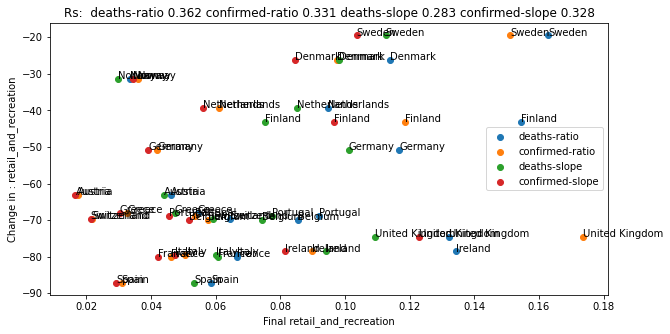

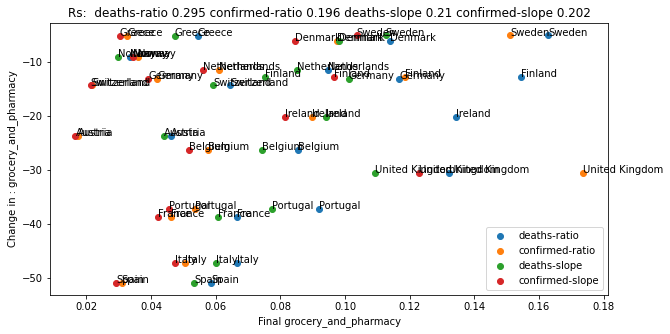

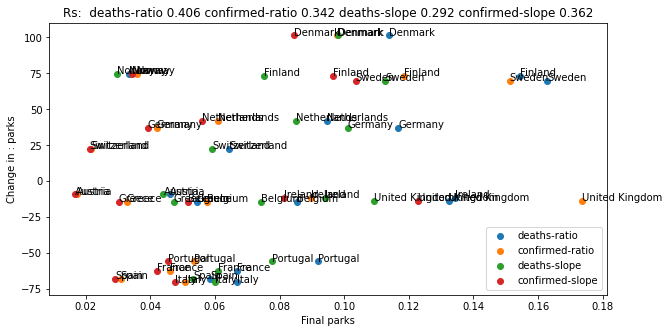

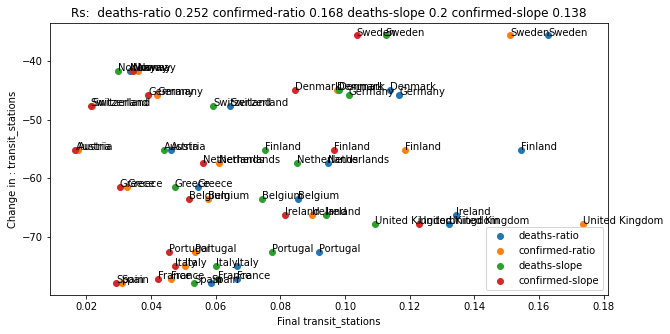

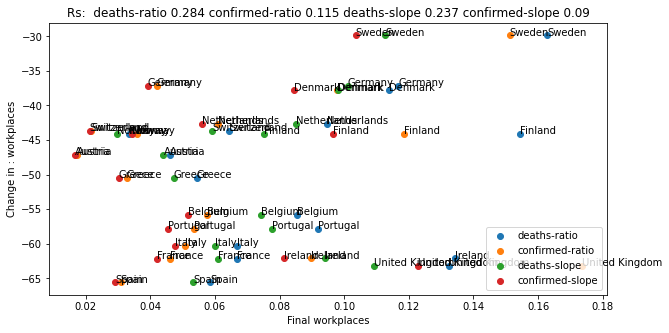

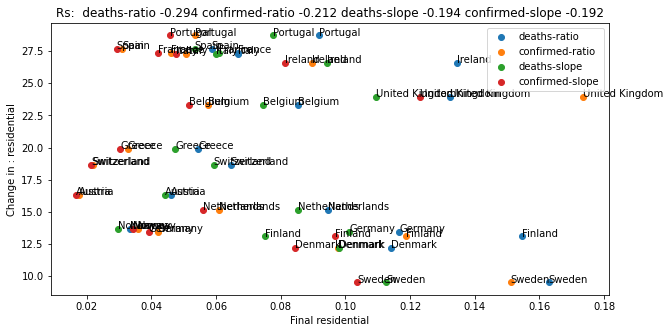

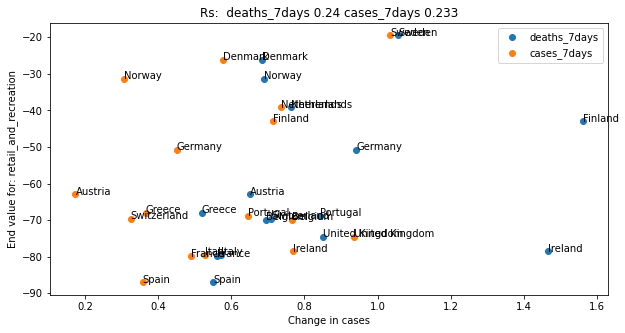

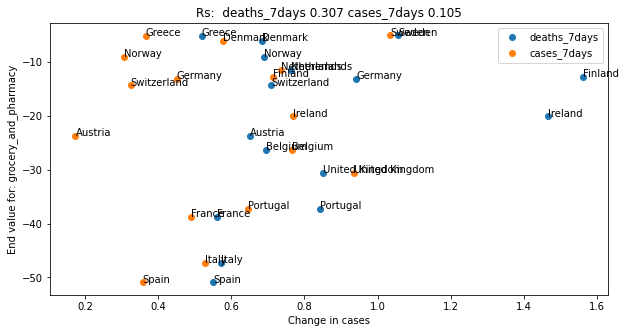

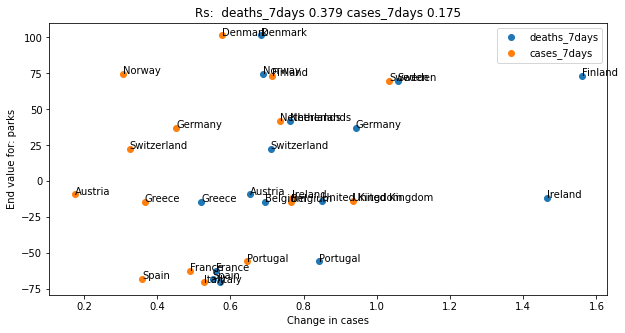

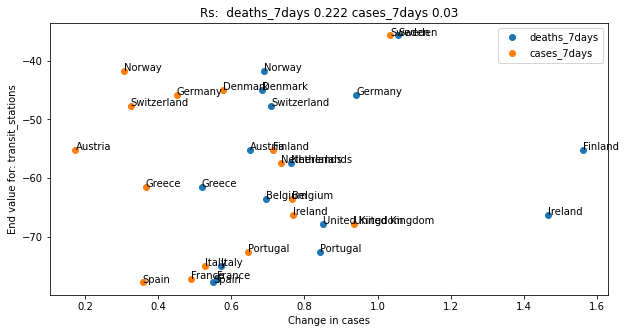

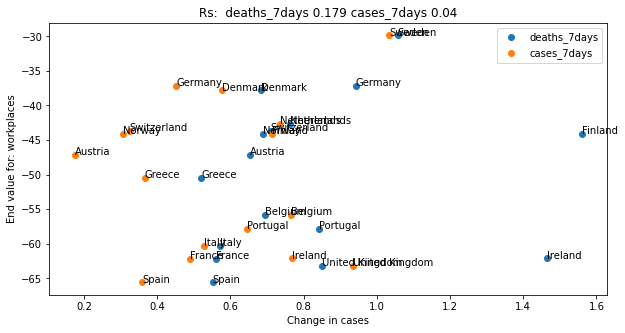

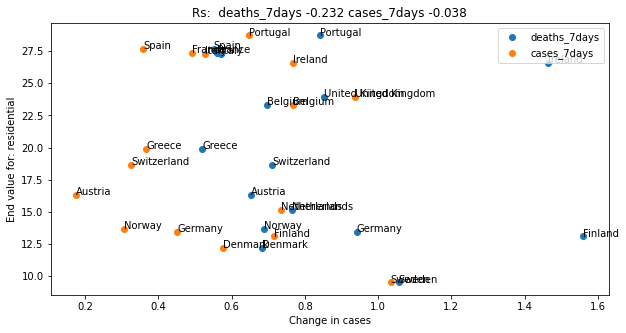

In [206]:

for col in columns:
    #print (col,new_df[col+"-end"],new_df[col+"-max"])
    new_df[col+"-diff"]=new_df[col+"-end"]/(new_df[col+"-max"])
for col in mobcolumns+R0cols+extracols:
    #print (col,new_df[col+"-end"],new_df[col+"-max"])
    new_df[col+"-diff"]=new_df[col+"-end"] # -new_df[col+"-max"]


    
for mobi in mobcolumns:
    fig, ax=plt.subplots(figsize=(10,5))
    corr={}
    title="Rs: "
    for col in extracols:
        #print(col,new_df[col+"-diff"],new_df[mobi+"-diff"])
        ax.scatter(new_df[col+"-diff"],new_df[mobi+"-diff"],label=col)
        for i, txt in enumerate(new_df[col+"-diff"]):
            ax.annotate(new_df["country"][i], (new_df[col+"-diff"][i], new_df[mobi+"-diff"][i]))
        #print (new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())
        corr[col]=np.corrcoef(new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())[0,1]
        #print (col,corr[col])
        title=title+" "+col+" "+str(round(corr[col],3))                  
    ax.set(title=title)
    ax.set(xlabel="Final "+mobi)
    ax.set(ylabel="Change in : "+mobi)
    ax.legend()    
    
    
for mobi in mobcolumns:
    fig, ax=plt.subplots(figsize=(10,5))
    corr={}
    title="Rs: "
    for col in columns:
        #print(col,new_df[ocl+"-diff"],new_df[mobi+"-diff"])
        ax.scatter(new_df[col+"-diff"],new_df[mobi+"-diff"],label=col)
        for i, txt in enumerate(new_df[col+"-diff"]):
            ax.annotate(new_df["country"][i], (new_df[col+"-diff"][i], new_df[mobi+"-diff"][i]))
        #print (new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())
        corr[col]=np.corrcoef(new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())[0,1]
        #print (col,corr[col])
        title=title+" "+col+" "+str(round(corr[col],3))                  
    ax.set(title=title)
    ax.set(xlabel="Change in cases")
    ax.set(ylabel="End value for: "+mobi)
    ax.legend()    


In [187]:
merged_df

index  Unnamed: 0      country        R0      sdR0  R0-FixSI  \
0      16988          42  Afghanistan  5.004790  5.003458       5.0   
1      16989          43  Afghanistan  4.995471  5.000871       5.0   
2      16990          44  Afghanistan  5.004039  5.002573       5.0   
3      16991          45  Afghanistan  4.995535  4.993644       5.0   
4      16992          46  Afghanistan  5.001136  4.999603       5.0   
...      ...         ...          ...       ...       ...       ...   
38807  45425       28479     Zimbabwe  1.000000       NaN       NaN   
38808  45426       28480     Zimbabwe  1.000000       NaN       NaN   
38809  45427       28481     Zimbabwe  1.000000       NaN       NaN   
38810  45428       28482     Zimbabwe  1.000000       NaN       NaN   
38811  45429       28483     Zimbabwe  1.000000       NaN       NaN   

       sdR0-FixSI  new_confirmed_cases  new_deaths       date  ...  \
0             5.0                  0.0         0.0 2020-02-15  ...   
1             5.0                  0.0         0.0 2020-02-16  ...   
2             5.0                  0.0         0.0 2020-02-17  ...   
3             5.0                  0.0         0.0 2020-02-18  ...   
4             5.0                  0.0         0.0 2020-02-19  ...   
...           ...                  ...         ...        ...  ...   
38807         NaN                  0.0         0.0 2020-05-19  ...   
38808         NaN                  0.0         0.0 2020-05-20  ...   
38809         NaN                  2.0         0.0 2020-05-21  ...   
38810         NaN                  3.0         0.0 2020-05-22  ...   
38811         NaN                  5.0         0.0 2020-05-23  ...   

       transit_stationsmaxderivative  workplaces-derivate  \
0                                NaT                  NaN   
1                                NaT                  NaN   
2                                NaT                  NaN   
3                                NaT                  NaN   
4                                NaT                  NaN   
...                              ...                  ...   
38807                     2020-05-10            -0.142857   
38808                     2020-05-10            -1.214286   
38809                     2020-05-10            -2.285714   
38810                     2020-05-10            -2.785714   
38811                     2020-05-10            -2.000000   

       workplacesminderivative  workplacesmaxderivative  residential-derivate  \
0                          NaT                      NaT                   NaN   
1                          NaT                      NaT                   NaN   
2                          NaT                      NaT                   NaN   
3                          NaT                      NaT                   NaN   
4                          NaT                      NaT                   NaN   
...                        ...                      ...                   ...   
38807               2020-04-05               2020-05-10             -0.107143   
38808               2020-04-05               2020-05-10              0.375000   
38809               2020-04-05               2020-05-10              0.750000   
38810               2020-04-05               2020-05-10              1.125000   
38811               2020-04-05               2020-05-10              0.500000   

       residentialminderivative residentialmaxderivative  R0-derivate  \
0                           NaT                      NaT          NaN   
1                           NaT                      NaT          NaN   
2                           NaT                      NaT          NaN   
3                           NaT                      NaT          NaN   
4                           NaT                      NaT          NaN   
...                         ...                      ...          ...   
38807                2020-05-10               2020-04-05     0.962925   
38808                20

                                           country R0minderivative
country                                                           
Australia                                Australia      2020-02-04
Cambodia                                  Cambodia      2020-02-06
Canada                                      Canada      2020-02-05
China                                        China      2020-01-29
Finland                                    Finland      2020-02-08
Japan                                        Japan      2020-02-08
Malaysia                                  Malaysia      2020-02-04
Russia                                      Russia      2020-02-10
Singapore                                Singapore      2020-02-03
Taiwan                                      Taiwan      2020-02-02
Thailand                                  Thailand      2020-01-23
United Arab Emirates          United Arab Emirates      2020-02-06
United Kingdom                      United Kingdom      2020-0

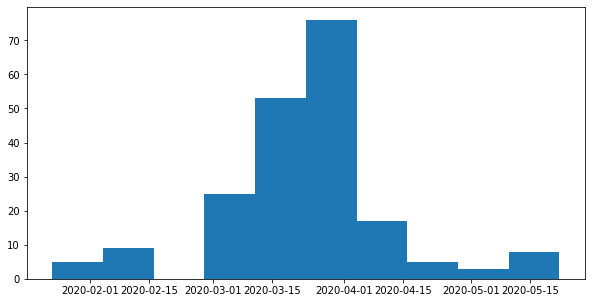

In [152]:
dates=merged_df.groupby(['country'])["country","R0minderivative"].first()

fig,ax=plt.subplots(figsize=(10,5))
ax.hist(dates.R0minderivative)
significant=dates.loc[dates.R0minderivative<datetime.strptime("2020-03-01","%Y-%m-%d")]
print (significant)
significant=dates.loc[dates.R0minderivative>datetime.strptime("2020-04-15","%Y-%m-%d")]
print (significant)
print (dates)

#ax=sns.distplot(dates.R0minderivative, hist = False, kde = True, rug = True,
#             color = 'darkgreen', 
#             kde_kws={'linewidth': 3},
#             rug_kws={'color': 'green'},label="Others")

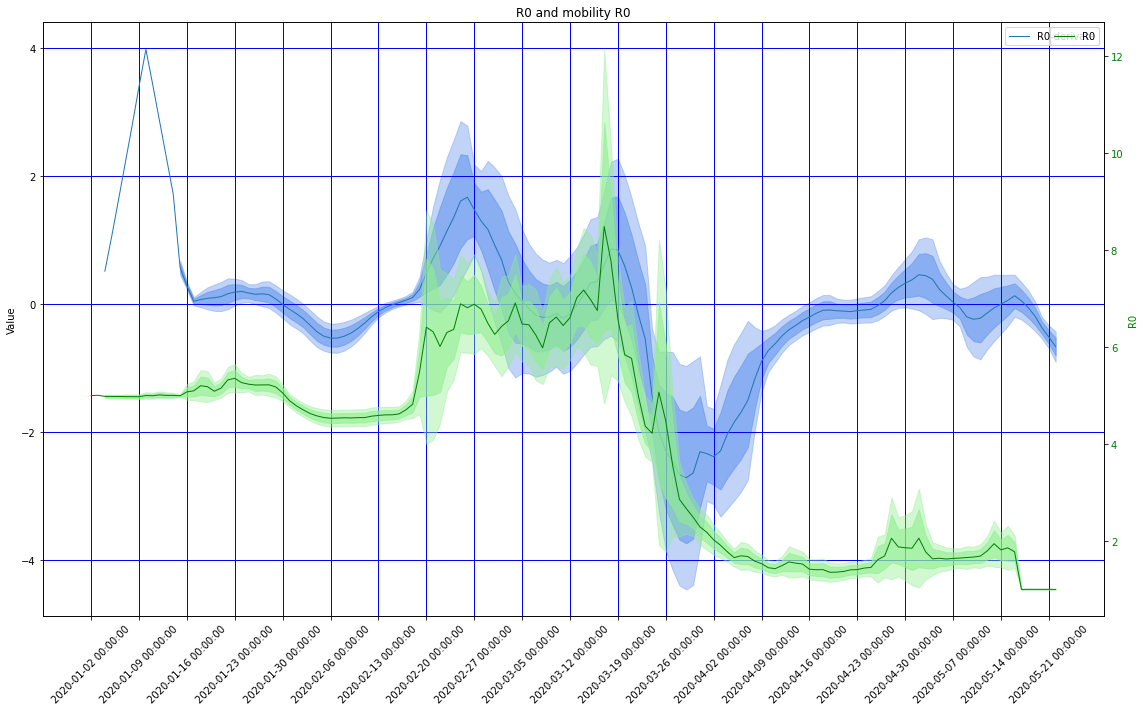

In [36]:
plot_time_new(merged_df,"foo.png","R0",["R0-derivate"])

In [50]:
mindata=pd.DataFrame(["ccountry","date"])
for country in countries:
    temp_df=merged_df.loc[merged_df.country==country]
print (mindate)

2020-03-04 00:00:00
2020-03-19 00:00:00
2020-03-11 00:00:00
2020-03-27 00:00:00
2020-04-01 00:00:00
2020-03-23 00:00:00
2020-03-15 00:00:00
2020-03-24 00:00:00
2020-03-20 00:00:00
2020-02-04 00:00:00
2020-03-07 00:00:00
2020-03-11 00:00:00
2020-03-26 00:00:00
2020-03-05 00:00:00
2020-03-17 00:00:00
2020-03-29 00:00:00
2020-03-09 00:00:00
2020-03-13 00:00:00
2020-04-02 00:00:00
2020-03-27 00:00:00
2020-03-30 00:00:00
2020-05-21 00:00:00
2020-03-22 00:00:00
2020-03-13 00:00:00
2020-04-11 00:00:00
2020-03-29 00:00:00
2020-04-06 00:00:00
2020-03-21 00:00:00
2020-03-19 00:00:00
2020-03-27 00:00:00
2020-04-10 00:00:00
2020-02-06 00:00:00
2020-03-15 00:00:00
2020-02-05 00:00:00
2020-04-26 00:00:00
2020-03-29 00:00:00
2020-05-07 00:00:00
2020-03-30 00:00:00
2020-03-14 00:00:00
2020-01-29 00:00:00
2020-03-22 00:00:00
2020-05-12 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-21 00:00:00
2020-03-07 00:00:00
2020-03-20 00:00:00
2020-05-05 00:00:00
2020-03-21 00:00:00
2020-03-12 00:00:00


In [49]:
merged_df

Unnamed: 0      country        R0      sdR0  R0-FixSI  sdR0-FixSI  \
0               0  Afghanistan  5.006418  4.997506       5.0         5.0   
1               1  Afghanistan  4.998323  4.995612       5.0         5.0   
2               2  Afghanistan  4.989282  4.985760       5.0         5.0   
3               3  Afghanistan  5.001742  4.999842       5.0         5.0   
4               4  Afghanistan  5.001094  5.006346       5.0         5.0   
...           ...          ...       ...       ...       ...         ...   
28277       28277     Zimbabwe  1.000000       NaN       NaN         NaN   
28278       28278     Zimbabwe  1.000000       NaN       NaN         NaN   
28279       28279     Zimbabwe  1.000000       NaN       NaN         NaN   
28280       28280     Zimbabwe  1.000000       NaN       NaN         NaN   
28281       28281     Zimbabwe  1.000000       NaN       NaN         NaN   

       new_confirmed_cases  new_deaths       date  deaths  ...  \
0                      0.0         0.0 2020-01-04     0.0  ...   
1                      0.0         0.0 2020-01-05     0.0  ...   
2                      0.0         0.0 2020-01-06     0.0  ...   
3                      0.0         0.0 2020-01-07     0.0  ...   
4                      0.0         0.0 2020-01-08     0.0  ...   
...                    ...         ...        ...     ...  ...   
28277                  2.0         0.0 2020-05-18     4.0  ...   
28278                  0.0         0.0 2020-05-19     4.0  ...   
28279                  0.0         0.0 2020-05-20     4.0  ...   
28280                  2.0         0.0 2020-05-21     4.0  ...   
28281                  3.0         0.0 2020-05-22     4.0  ...   

       residential_10days  R0_7days  R0_10days  \
0                  0.0000       NaN        NaN   
1                  0.0000       NaN        NaN   
2                  0.0000       NaN        NaN   
3                  0.0000       NaN        NaN   
4                  0.0000       NaN        NaN   
...                   ...       ...        ...   
28277             27.5875  2.641916   2.430538   
28278             28.0250  2.489499   2.352049   
28279             28.5625  2.083850   2.256167   
28280             28.4000  1.690815   2.149341   
28281             28.3375  1.277880   2.042649   

       retail_and_recreation-derivate  grocery_and_pharmacy-derivate  \
0                                 NaN                            NaN   
1                                 NaN                            NaN   
2                                 NaN                            NaN   
3                                 NaN                            NaN   
4                                 NaN                            NaN   
...                               ...                            ...   
28277                        1.339286                       0.946429   
28278                        0.321429                       0.250000   
28279                        0.017857                      -0.017857   
28280                        0.321429                       0.107143   
28281                        0.196429                       0.232143   

      parks-derivate  transit_stations-derivate  workplaces-derivate  \
0                NaN                        NaN                  NaN   
1                NaN                        NaN                  NaN   
2                NaN                        NaN                  NaN   
3                NaN                        NaN                  NaN   
4                NaN                        NaN                  NaN   
...              ...                        ...                  ...   
28277       1.017857                   2.517857             0.785714   
28278       0.964286                   0.821429            -0.142857   
28279      -0.089286                  -0.017857            -1.214286   
28280      -0.607143                  -0.035714            -2.285714   
28281      -1.267857                  -0.33

In [483]:
def get_correlations(temp_df,countries,key,numdays):
    x=[]
    y=[]
    for country in countries:
        temp_df=data_df.loc[(data_df.country==country)]
        for i in np.arange(-1*numdays,numdays):
            #for key in mobilitycolumns:
            temp_df["shift"]=temp_df[key].shift(i)
            tmp=temp_df[["shift","R0"]].dropna()
            #print (country,key,i,tmp.corr(method="pearson").R0[0])
            #corr[i+numdays,j]=tmp.corr(method="pearson").R0[0]
            c=tmp.corr(method="pearson").R0[0]
            if (not np.isnan(c)):
                x+=[i]
                y+=[c]
            else:
                print ("Error:",country,i,tmp)
    return [x],[y]

In [498]:
corr_df=merged_df[merged_df.date>datetime.strptime("2020-04-15","%Y-%m-%d")]
corr_df.dropna()

Unnamed: 0      country        R0      sdR0  R0-FixSI  sdR0-FixSI  \
103           103  Afghanistan  1.209791  0.093159  1.103316    0.058641   
104           104  Afghanistan  1.279469  0.085907  1.200955    0.060813   
105           105  Afghanistan  1.161998  0.076915  1.113045    0.058100   
106           106  Afghanistan  1.165249  0.073254  1.116979    0.057375   
107           107  Afghanistan  1.177575  0.071108  1.125257    0.056762   
...           ...          ...       ...       ...       ...         ...   
28271       28271     Zimbabwe  2.066921  1.274534  1.814381    0.907191   
28272       28272     Zimbabwe  3.839540  1.819389  3.183193    1.125429   
28273       28273     Zimbabwe  3.751248  1.555385  3.192652    1.064217   
28274       28274     Zimbabwe  3.890545  1.528538  3.162602    0.953560   
28275       28275     Zimbabwe  2.945159  1.242415  2.211683    0.699395   

       new_confirmed_cases  new_deaths       date  deaths  ...  parks_7days  \
103                   70.0         2.0 2020-04-16    25.0  ...   -12.857143   
104                   10.0         4.0 2020-04-17    29.0  ...   -13.142857   
105                   51.0         1.0 2020-04-18    30.0  ...   -13.571429   
106                   63.0         0.0 2020-04-19    30.0  ...   -13.285714   
107                   88.0         3.0 2020-04-20    33.0  ...   -13.285714   
...                    ...         ...        ...     ...  ...          ...   
28271                  1.0         0.0 2020-05-12     4.0  ...   -30.857143   
28272                  0.0         0.0 2020-05-13     4.0  ...   -30.285714   
28273                  0.0         0.0 2020-05-14     4.0  ...   -29.767857   
28274                  0.0         0.0 2020-05-15     4.0  ...   -29.107143   
28275                  5.0         0.0 2020-05-16     4.0  ...   -29.160714   

       parks_10days  transit_stations_7days  transit_stations_10days  \
103        -12.6000              -50.285714                 -50.1000   
104        -12.7000              -50.714286                 -50.6000   
105        -13.0000              -50.714286                 -50.4000   
106        -13.3000              -50.714286                 -50.2000   
107        -13.6000              -50.571429                 -50.4000   
...             ...                     ...                      ...   
28271      -31.0000              -57.285714                 -59.1000   
28272      -30.4000              -56.857143                 -57.7000   
28273      -30.3375              -56.839286                 -57.2875   
28274      -30.3750              -56.535714                 -56.8750   
28275      -30.3125              -56.517857                 -56.8625   

       workplaces_7days workplaces_10days  residential_7days  \
103          -37.000000            -38.00          14.428571   
104          -36.571429            -35.40          14.428571   
105          -36.285714            -34.80          14.142857   
106          -36.142857            -34.80          13.857143   
107          -35.714286            -37.00          13.571429   
...                 ...               ...                ...   
28271        -29.428571            -30.50          28.428571   
28272        -28.285714            -31.50          28.000000   
28273        -27.214286            -30.45          27.625000   
28274        -26.714286            -29.50          27.250000   
28275        -27.500000            -28.65          27.875000   

       residential_10days  R0_7days  R0_10days  
103               14.2000  1.399185   1.489545  
104               14.3000  1.351306   1.448161  
105               14.3000  1.291202   1.386287  
106               13.9000  1.237000   1.340101  
107               14.0000  1.192750   1.296396  
...                   ...       ...        ...  
28271             28.7000  1.526573   1.173085  
28272             28.9000  1.988791   1.498907  
28273             28.5375  2.377905   1.852815  
28274             28.

In [499]:
corr_df=merged_df[(merged_df.date>datetime.strptime("2020-03-01","%Y-%m-%d")) &
                      (merged_df.date<datetime.strptime("2020-04-15","%Y-%m-%d"))]

corr_df.dropna()

Unnamed: 0      country        R0      sdR0  R0-FixSI  sdR0-FixSI  \
58             58  Afghanistan  1.089759  1.144064  0.978908    0.978908   
59             59  Afghanistan  1.161238  1.263202  1.183987    1.183987   
60             60  Afghanistan  1.300730  1.444916  1.516086    1.516086   
61             61  Afghanistan  6.048467  3.855431  7.891393    3.945696   
62             62  Afghanistan  6.035116  3.418588  8.969709    4.484855   
...           ...          ...       ...       ...       ...         ...   
28239       28239     Zimbabwe  1.936150  0.810994  2.116611    0.864103   
28240       28240     Zimbabwe  2.886602  1.022849  2.927800    0.975933   
28241       28241     Zimbabwe  2.417816  0.959542  2.234027    0.789848   
28242       28242     Zimbabwe  3.561802  1.238459  2.956070    0.819866   
28243       28243     Zimbabwe  3.336264  1.222419  2.620009    0.700227   

       new_confirmed_cases  new_deaths       date  deaths  ...  parks_7days  \
58                     0.0         0.0 2020-03-02     0.0  ...     1.428571   
59                     0.0         0.0 2020-03-03     0.0  ...     1.571429   
60                     0.0         0.0 2020-03-04     0.0  ...     1.428571   
61                     0.0         0.0 2020-03-05     0.0  ...     1.571429   
62                     0.0         0.0 2020-03-06     0.0  ...     2.571429   
...                    ...         ...        ...     ...  ...          ...   
28239                  0.0         1.0 2020-04-10     3.0  ...   -49.571429   
28240                  0.0         0.0 2020-04-11     3.0  ...   -49.000000   
28241                  3.0         0.0 2020-04-12     3.0  ...   -48.714286   
28242                  0.0         0.0 2020-04-13     3.0  ...   -49.142857   
28243                  3.0         0.0 2020-04-14     3.0  ...   -48.857143   

       parks_10days  transit_stations_7days  transit_stations_10days  \
58              2.2                5.857143                      6.4   
59              1.8                5.571429                      6.4   
60              1.7                5.000000                      5.6   
61              1.5                5.142857                      5.1   
62              2.2                5.142857                      4.6   
...             ...                     ...                      ...   
28239         -50.2              -78.714286                    -79.2   
28240         -50.3              -78.857143                    -79.3   
28241         -49.5              -79.285714                    -79.3   
28242         -49.1              -79.857143                    -79.5   
28243         -48.6              -79.857143                    -79.3   

       workplaces_7days workplaces_10days  residential_7days  \
58             6.714286               6.6           0.714286   
59             6.857143               6.8           0.714286   
60             7.142857               6.9           0.714286   
61             7.571429               7.2           0.571429   
62             8.000000               7.3           0.428571   
...                 ...               ...                ...   
28239        -62.285714             -64.5          40.714286   
28240        -62.571429             -63.3          40.571429   
28241        -62.428571             -59.7          40.714286   
28242        -64.285714             -60.9          41.428571   
28243        -63.857143             -61.7          41.285714   

       residential_10days  R0_7days  R0_10days  
58                    0.6  2.951447   4.760689  
59                    0.6  2.234713   3.875695  
60                    0.6  1.745688   3.089481  
61                    0.7  2.097469   2.917057  
62                    0.8  2.557000   2.902731  
...                   ...       ...        ...  
28239                42.1  1.162136   1.061852  
28240                41.3  1.479586   1.233123  
28241                40.1  1.725204   1.408965  
28242                

In [490]:
numdays=21
corr_df=merged_df[merged_df.date>datetime.strptime("2020-04-15","%Y-%m-%d")]
corr_df=corr_df.dropna()
#tmpcountries=["Sweden","Finland","Italy"]
tmpcountries=corr_df.country.drop_duplicates()

colors = ['Reds','Purples','Oranges','Greens','Blues',"Greys"]
i=0
#for col in mobilitycolumns:
#    print (col)
#    fig,ax=plt.subplots(figsize=(10,5))
#    [x],[y]=get_correlations(corr_df,tmpcountries,col,21)
#    #print(x,y)
#    sns.kdeplot(x,y,shade=True,cmap=colors[i])
#    i+=1
#    fig.savefig("foo.png")
#    fig.show()
#    plt.close()
    #sys.exit()


In [ ]:
countries

/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


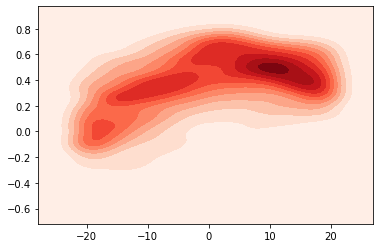

In [491]:
plt.close()

i=0    
[x],[y]=get_correlations(corr_df,tmpcountries,"grocery_and_pharmacy",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])


/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[-21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,

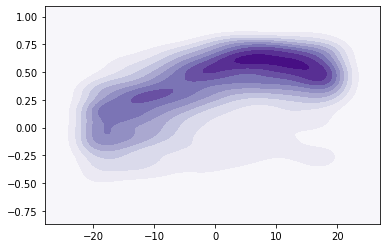

In [492]:
plt.close()
i=1    
[x],[y]=get_correlations(corr_df,tmpcountries,"parks",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])
#print(x,y)

/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


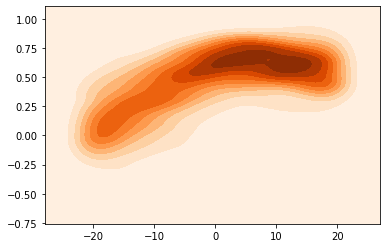

In [493]:
plt.close()
i=2    
[x],[y]=get_correlations(corr_df,tmpcountries,"transit_stations",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])


/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


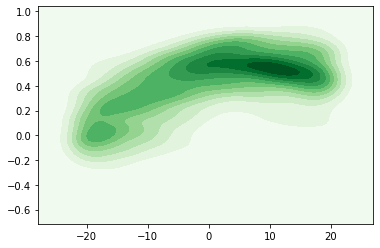

In [494]:
plt.close()
i=3      
[x],[y]=get_correlations(corr_df,tmpcountries,"workplaces",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])


/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


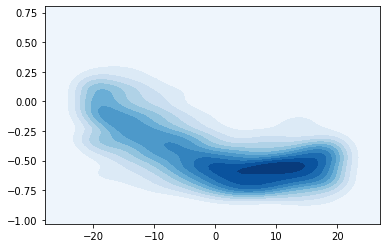

In [495]:
plt.close()
i=4    
[x],[y]=get_correlations(corr_df,tmpcountries,"residential",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])

/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


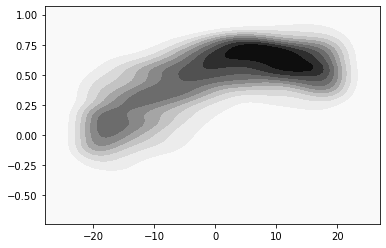

In [496]:
plt.close()
i=5    
[x],[y]=get_correlations(corr_df,tmpcountries,"retail_and_recreation",21)
sns.kdeplot(x,y,shade=True,cmap=colors[i])


In [467]:
corr_df

Unnamed: 0      country        R0      sdR0  R0-FixSI  sdR0-FixSI  \
89             89  Afghanistan  1.954479  0.372642  1.547444    0.120468   
90             90  Afghanistan  1.927462  0.332374  1.556072    0.114097   
91             91  Afghanistan  1.806750  0.287467  1.497788    0.106713   
92             92  Afghanistan  1.658554  0.245322  1.399868    0.098494   
93             93  Afghanistan  1.723737  0.232282  1.471991    0.096641   
...           ...          ...       ...       ...       ...         ...   
28277       28277     Zimbabwe  1.000000       NaN       NaN         NaN   
28278       28278     Zimbabwe  1.000000       NaN       NaN         NaN   
28279       28279     Zimbabwe  1.000000       NaN       NaN         NaN   
28280       28280     Zimbabwe  1.000000       NaN       NaN         NaN   
28281       28281     Zimbabwe  1.000000       NaN       NaN         NaN   

       new_confirmed_cases  new_deaths       date  deaths  ...  parks_7days  \
89                    26.0         0.0 2020-04-02     4.0  ...   -10.000000   
90                    43.0         0.0 2020-04-03     4.0  ...   -10.857143   
91                     0.0         0.0 2020-04-04     4.0  ...   -11.428571   
92                    35.0         1.0 2020-04-05     5.0  ...   -11.428571   
93                    29.0         2.0 2020-04-06     7.0  ...   -10.857143   
...                    ...         ...        ...     ...  ...          ...   
28277                  2.0         0.0 2020-05-18     4.0  ...   -29.839286   
28278                  0.0         0.0 2020-05-19     4.0  ...   -29.892857   
28279                  0.0         0.0 2020-05-20     4.0  ...   -30.375000   
28280                  2.0         0.0 2020-05-21     4.0  ...   -30.375000   
28281                  3.0         0.0 2020-05-22     4.0  ...   -30.375000   

       parks_10days  transit_stations_7days  transit_stations_10days  \
89          -7.8000              -33.714286                 -30.0000   
90          -8.5000              -36.000000                 -31.4000   
91          -9.3000              -36.857143                 -32.9000   
92         -10.2000              -37.142857                 -34.2000   
93         -11.1000              -37.285714                 -36.6000   
...             ...                     ...                      ...   
28277      -29.4875              -55.910714                 -56.6375   
28278      -29.5250              -56.464286                 -56.6250   
28279      -29.6625              -56.875000                 -55.9125   
28280      -30.0000              -56.875000                 -56.2000   
28281      -30.0375              -56.875000                 -56.5875   

       workplaces_7days workplaces_10days  residential_7days  \
89           -29.857143            -23.40          10.428571   
90           -31.285714            -24.10          10.571429   
91           -32.285714            -26.50          10.428571   
92           -33.000000            -29.30          10.714286   
93           -33.428571            -33.10          10.714286   
...                 ...               ...                ...   
28277        -29.785714            -27.55          28.410714   
28278        -29.571429            -28.10          28.321429   
28279        -29.500000            -29.85          28.375000   
28280        -29.500000            -29.70          28.375000   
28281        -29.500000            -29.55          28.375000   

       residential_10days  R0_7days  R0_10days  
89                 8.9000  2.560575   2.864803  
90                 9.2000  2.405925   2.727316  
91                 9.6000  2.228861   2.542965  
92                10.1000  2.037280   2.331679  
93                10.7000  1.954420   2.203052  
...                   ...       ...        ...  
28277             27.5875  2.641916   2.430538  
28278             28.0250  2.489499   2.352049  
28279             28.5625  2.083850   2.256167  
28280             28.

In [328]:
merged_df=merged_df.dropna()
merged_df

Unnamed: 0      country        R0      sdR0  R0-FixSI  sdR0-FixSI  \
9               9  Afghanistan  4.999869  5.003389  5.000000    5.000000   
10             10  Afghanistan  4.993319  4.994406  5.000000    5.000000   
11             11  Afghanistan  5.008603  5.009927  5.000000    5.000000   
12             12  Afghanistan  4.990776  4.987323  5.000000    5.000000   
13             13  Afghanistan  5.004758  5.001275  5.000000    5.000000   
...           ...          ...       ...       ...       ...         ...   
28271       28271     Zimbabwe  2.066921  1.274534  1.814381    0.907191   
28272       28272     Zimbabwe  3.839540  1.819389  3.183193    1.125429   
28273       28273     Zimbabwe  3.751248  1.555385  3.192652    1.064217   
28274       28274     Zimbabwe  3.890545  1.528538  3.162602    0.953560   
28275       28275     Zimbabwe  2.945159  1.242415  2.211683    0.699395   

       new_confirmed_cases  new_deaths       date  deaths  ...  parks_7days  \
9                      0.0         0.0 2020-01-13     0.0  ...     0.000000   
10                     0.0         0.0 2020-01-14     0.0  ...     0.000000   
11                     0.0         0.0 2020-01-15     0.0  ...     0.000000   
12                     0.0         0.0 2020-01-16     0.0  ...     0.000000   
13                     0.0         0.0 2020-01-17     0.0  ...     0.000000   
...                    ...         ...        ...     ...  ...          ...   
28271                  1.0         0.0 2020-05-12     4.0  ...   -30.857143   
28272                  0.0         0.0 2020-05-13     4.0  ...   -30.285714   
28273                  0.0         0.0 2020-05-14     4.0  ...   -29.767857   
28274                  0.0         0.0 2020-05-15     4.0  ...   -29.107143   
28275                  5.0         0.0 2020-05-16     4.0  ...   -29.160714   

       parks_10days  transit_stations_7days  transit_stations_10days  \
9            0.0000                0.000000                   0.0000   
10           0.0000                0.000000                   0.0000   
11           0.0000                0.000000                   0.0000   
12           0.0000                0.000000                   0.0000   
13           0.0000                0.000000                   0.0000   
...             ...                     ...                      ...   
28271      -31.0000              -57.285714                 -59.1000   
28272      -30.4000              -56.857143                 -57.7000   
28273      -30.3375              -56.839286                 -57.2875   
28274      -30.3750              -56.535714                 -56.8750   
28275      -30.3125              -56.517857                 -56.8625   

       workplaces_7days workplaces_10days  residential_7days  \
9              0.000000              0.00           0.000000   
10             0.000000              0.00           0.000000   
11             0.000000              0.00           0.000000   
12             0.000000              0.00           0.000000   
13             0.000000              0.00           0.000000   
...                 ...               ...                ...   
28271        -29.428571            -30.50          28.428571   
28272        -28.285714            -31.50          28.000000   
28273        -27.214286            -30.45          27.625000   
28274        -26.714286            -29.50          27.250000   
28275        -27.500000            -28.65          27.875000   

       residential_10days  R0_7days  R0_10days  
9                  0.0000  5.000811   4.999970  
10                 0.0000  4.999608   4.998660  
11                 0.0000  5.000680   4.999688  
12                 0.0000  4.998623   4.999837  
13                 0.0000  4.998748   5.000139  
...                   ...       ...        ...  
28271             28.7000  1.526573   1.173085  
28272             28.9000  1.988791   1.498907  
28273             28.5375  2.377905   1.852815  
28274             28.

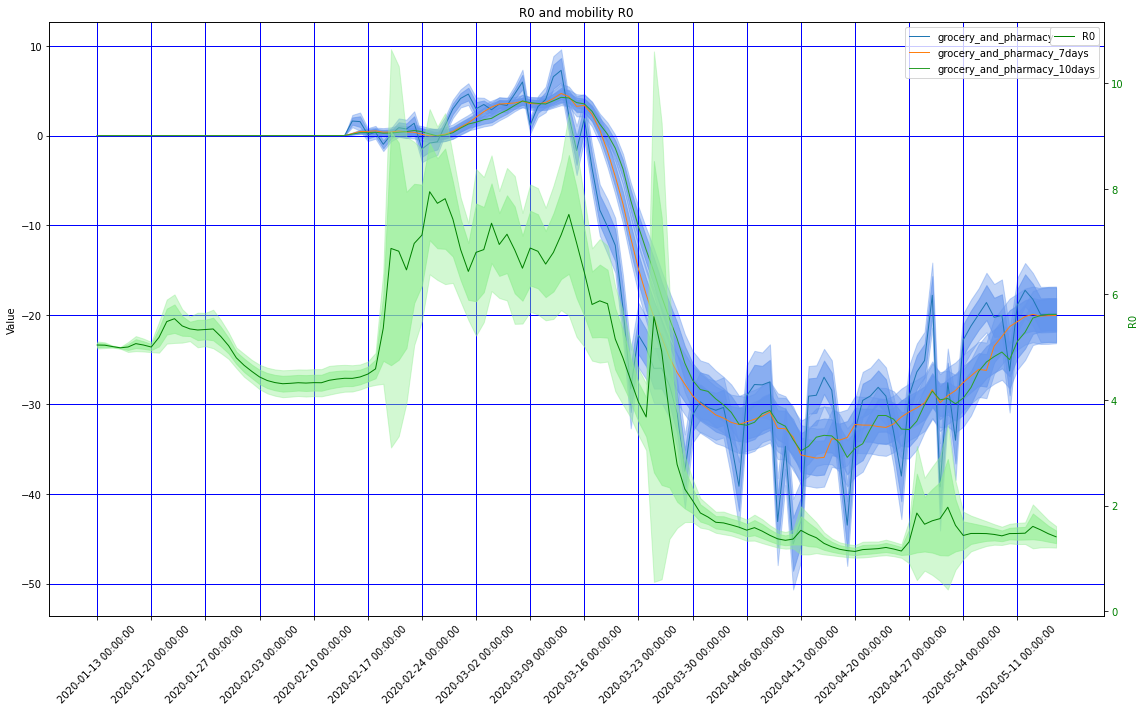

In [329]:
plot_time_new(merged_df,"foo.png","R0",["grocery_and_pharmacy","grocery_and_pharmacy_7days","grocery_and_pharmacy_10days"])

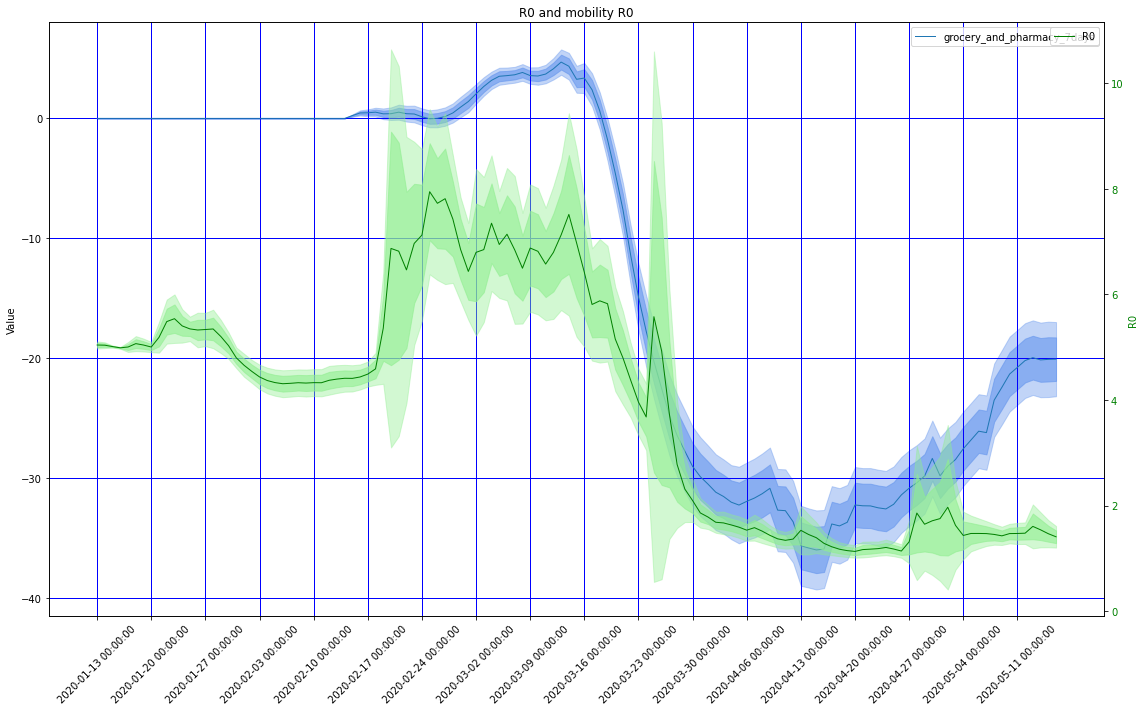

In [330]:
plot_time_new(merged_df,"foo.png","R0",["grocery_and_pharmacy_7days"])

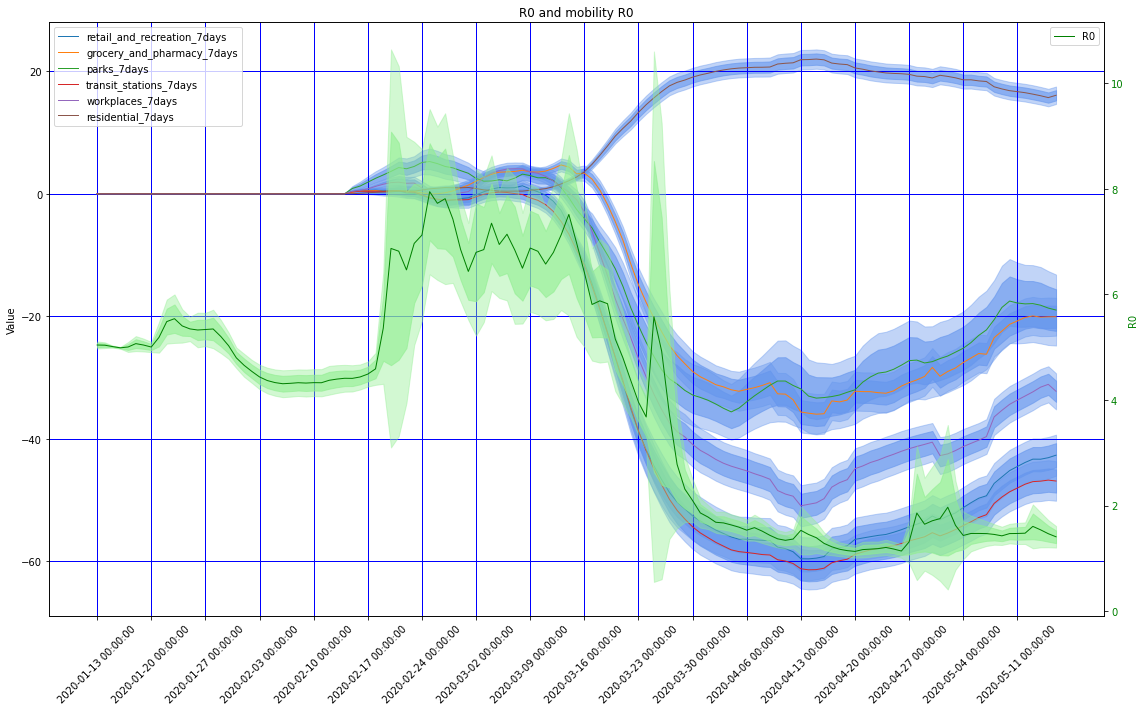

In [331]:
plot_time_new(merged_df,"foo.png","R0",["retail_and_recreation_7days",
                                        "grocery_and_pharmacy_7days","parks_7days",
                                        "transit_stations_7days","workplaces_7days",
                                        "residential_7days"])


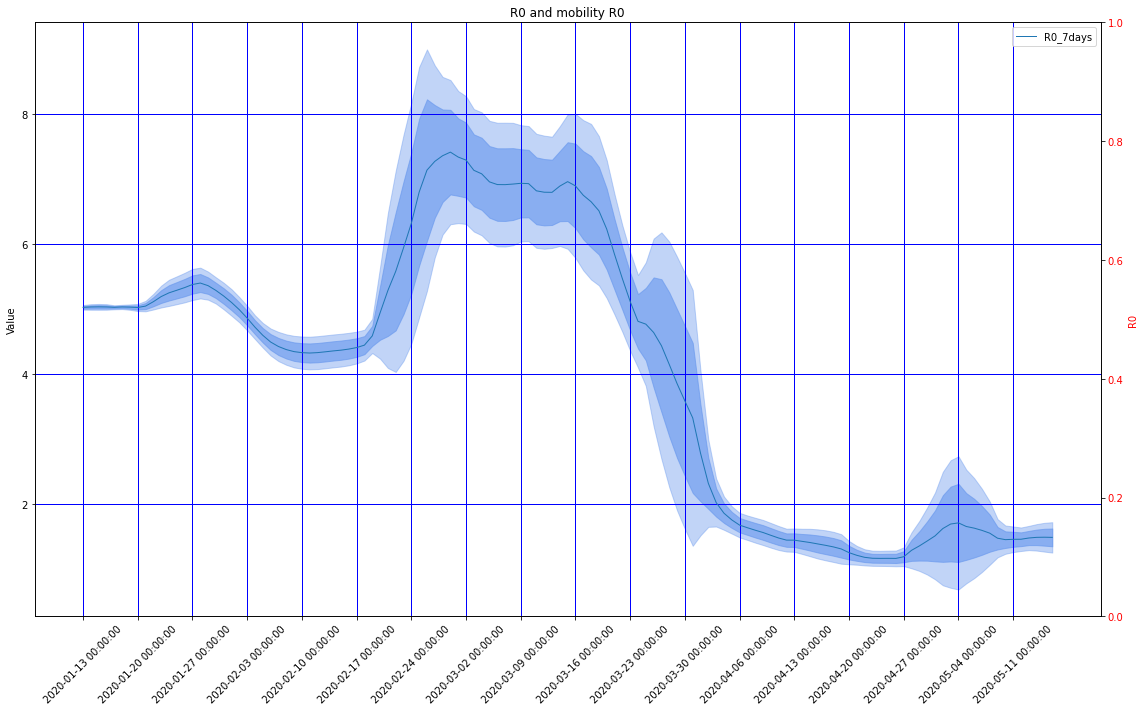

In [319]:
plot_time_new(merged_df,"foo.png","R0",["R0_7days"])

In [320]:
print (countries)

16850    Afghanistan
16990        Albania
17130        Algeria
17270        Andorra
17410         Angola
            ...     
44432      Venezuela
44572        Vietnam
44712          Yemen
44852         Zambia
44992       Zimbabwe
Name: country, Length: 201, dtype: object


In [ ]:
sys.exit()

/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/arnee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

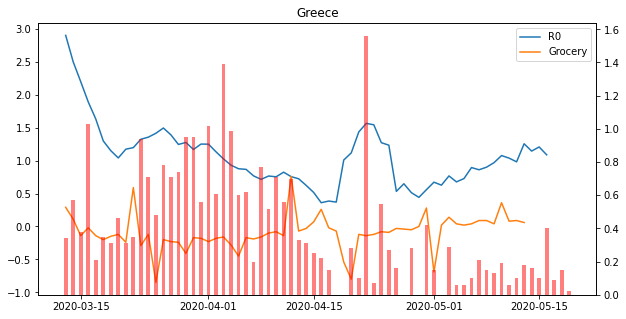

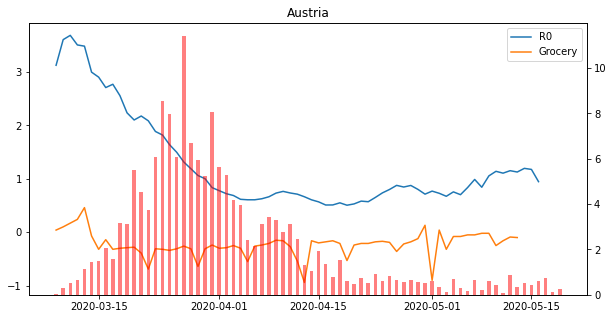

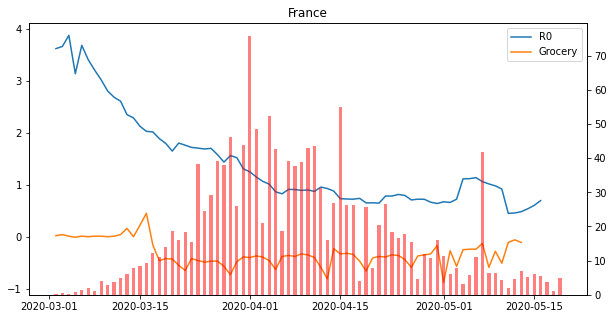

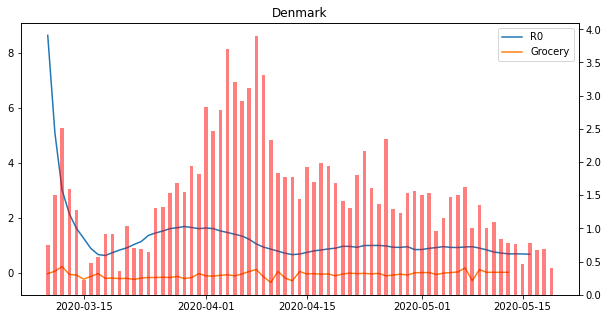

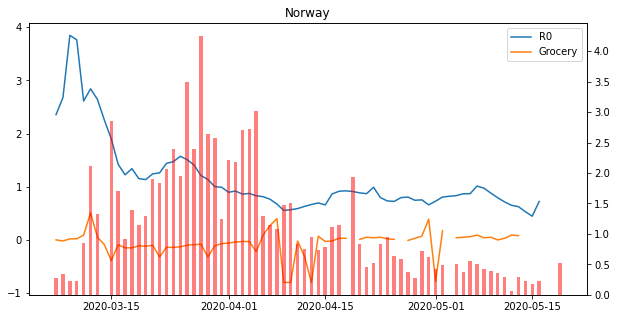

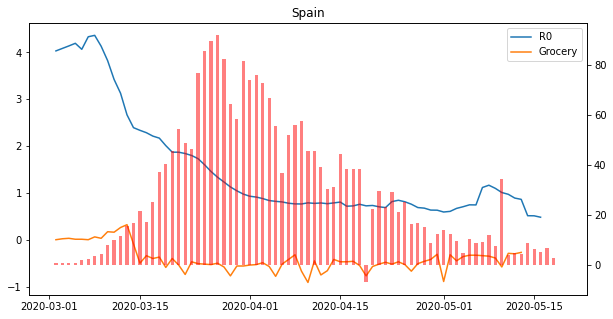

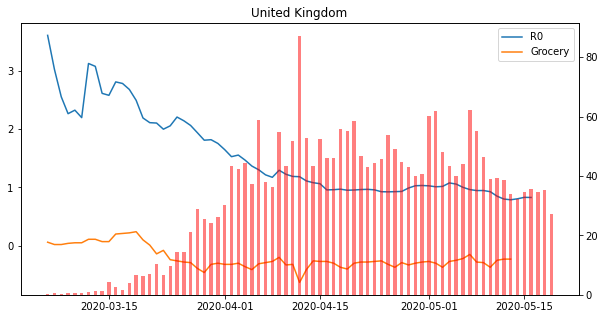

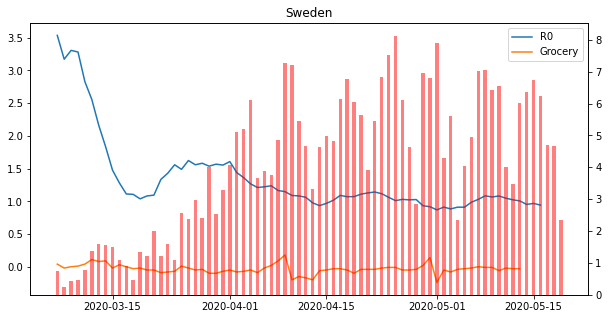

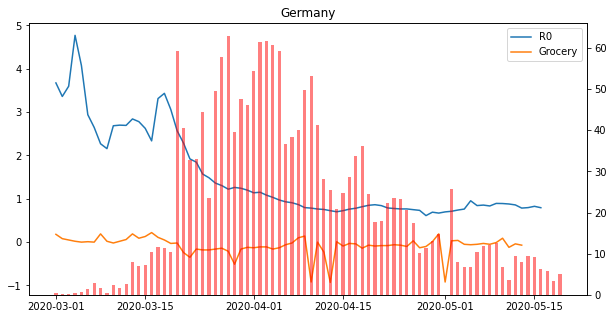

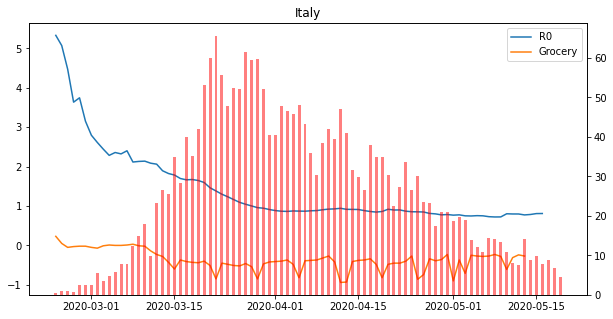

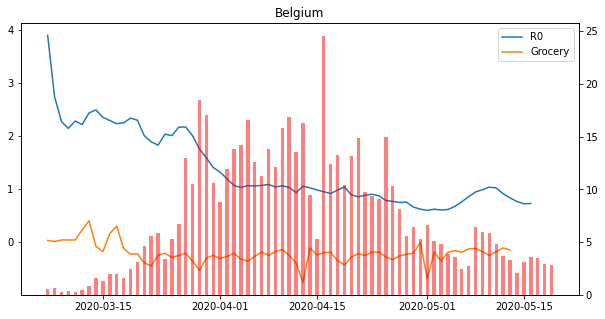

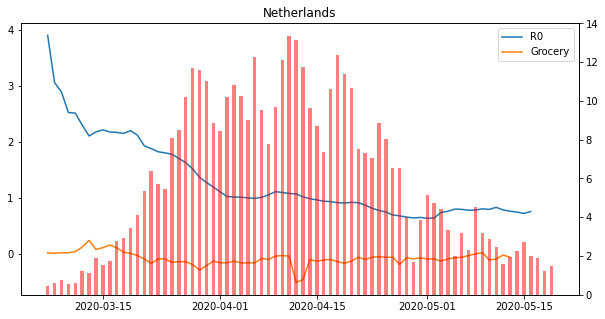

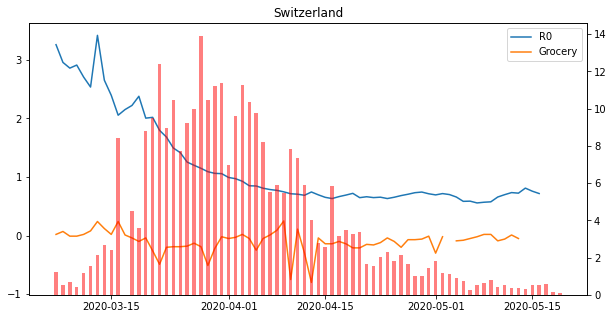

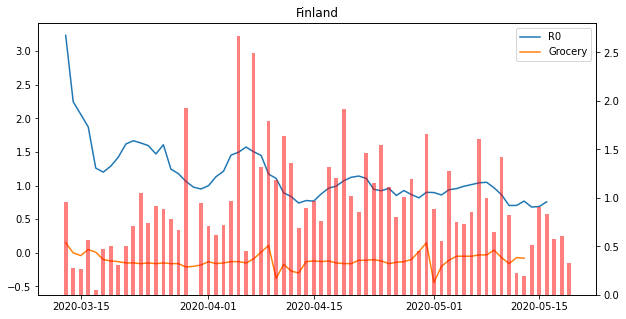

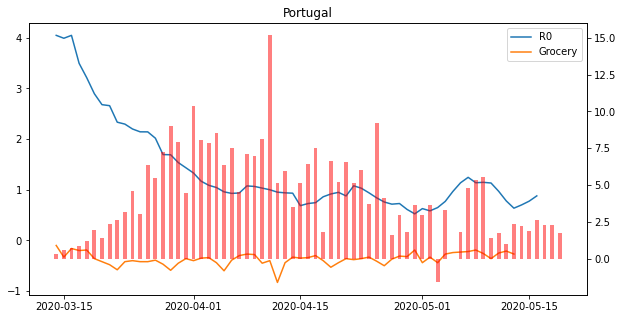

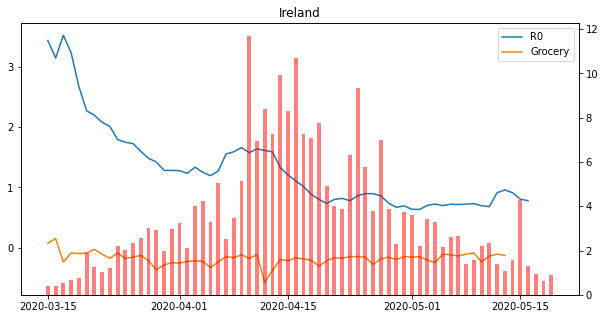

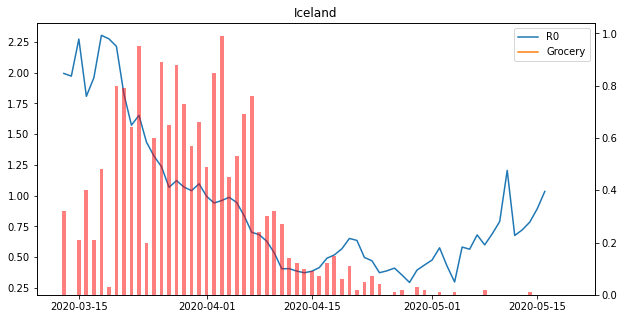

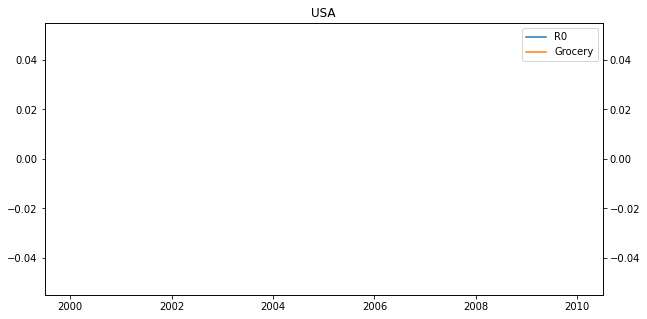

In [152]:
countries=["Greece","Austria","France","Denmark","Norway","Spain",
          "United Kingdom","Sweden","Germany","Italy","Belgium","Netherlands",
         "Switzerland","Finland","Portugal","Ireland","Iceland","USA"]
for c in countries:
    temp_df=data.loc[(data.country==c) & (data.confirmed>100)]
    #print(temp_df)
    temp_df["deltaGrocery"]=temp_df.grocery_and_pharmacy.diff(-7).fillna(0)
    temp_df["deltaTR"]=temp_df.transit_stations.diff(-7).fillna(0)
    temp_df["deltaR0"]=temp_df["R0-FixSI"].diff(-7).dropna()
    fig, ax=plt.subplots(figsize=(10,5))
    #ax.bar(temp_df.date,temp_df.deltaR0,color="b",width=0.2)
    #ax.bar(temp_df.date,temp_df.deltaGrocery/100,color="r",width=0.5,alpha=0.5)
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.bar(temp_df.date,temp_df.new_confirmed_cases/100,color="r",width=0.5,alpha=0.5,label="new cases")
    ax.plot(temp_df.date,temp_df["R0-FixSI"],label="R0")
    ax.plot(temp_df.date,temp_df.grocery_and_pharmacy/100,label="Grocery")
    ax.set_title(c)
    ax.legend()
    fig.show()


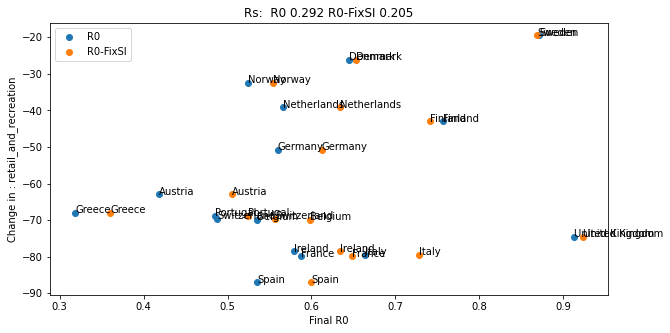

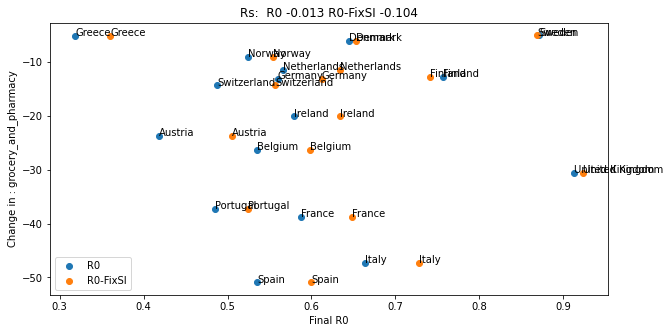

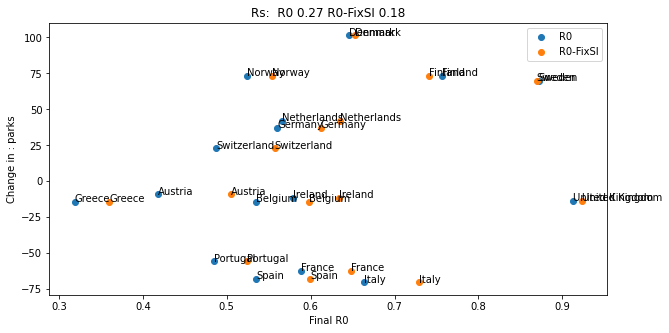

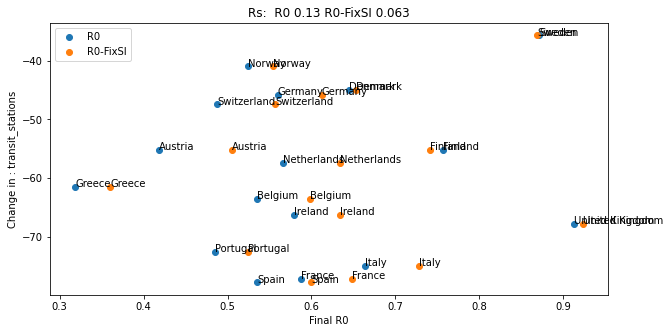

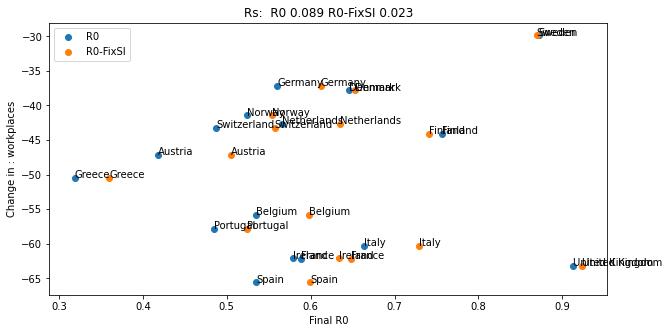

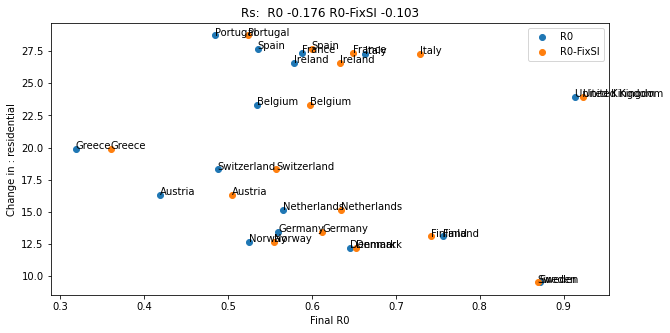

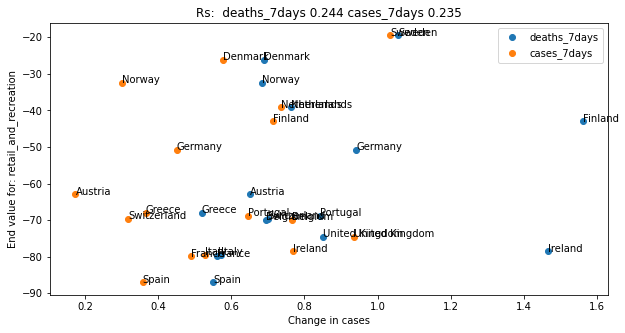

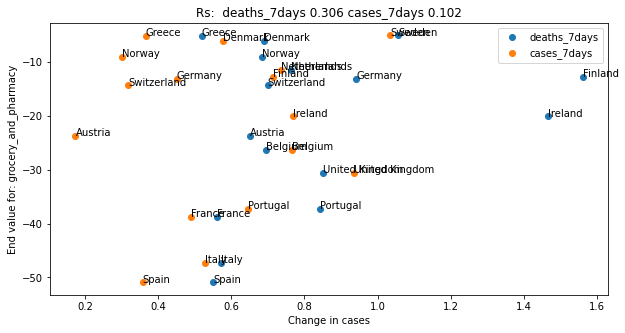

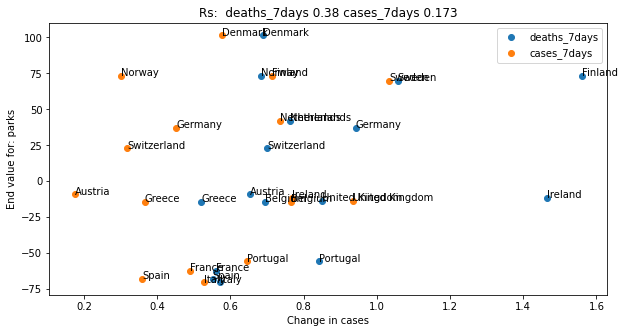

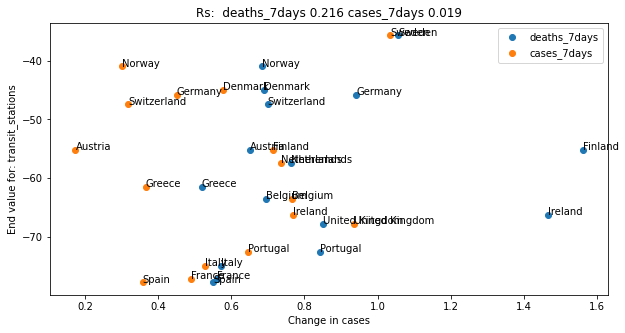

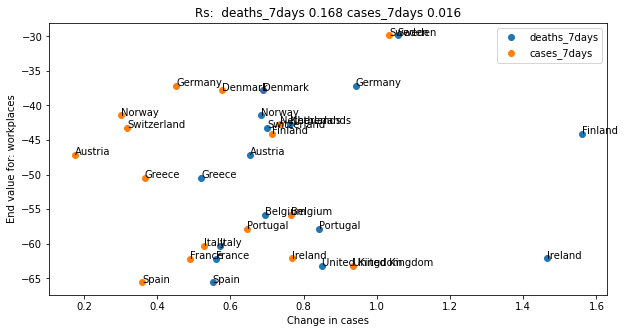

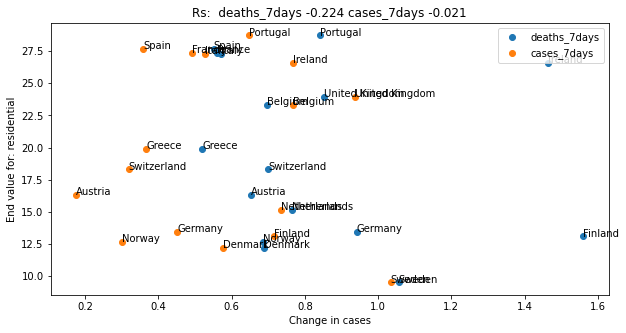

In [172]:
x=[]
y=[]
new_df=pd.DataFrame([])
columns=["deaths_7days","cases_7days"]
R0cols=["R0","R0-FixSI"]
mobcolumns=["retail_and_recreation","grocery_and_pharmacy","parks","transit_stations","workplaces","residential"]
start_trans=datetime.strptime("2020-03-15","%Y-%m-%d")
stop_trans=datetime.strptime("2020-04-15","%Y-%m-%d")
endrecovery=datetime.strptime("2020-05-08","%Y-%m-%d") # We need latest mobility data
lenrecovery=30
countries
country_df=pd.DataFrame([])
mincases=1000
mindeaths=100
countries=["Greece","Austria","France","Denmark","Norway","Spain",
          "United Kingdom","Sweden","Germany","Italy","Belgium","Netherlands",
          "Switzerland","Finland","Portugal","Ireland","Iceland","USA"]
for c in countries:
    temp_df=data.loc[(data.country==c)]
    if (temp_df.confirmed.max()<mincases): continue
    if (temp_df.deaths.max()<mindeaths): continue
    #print(temp_df)
    # Find max value of cases/detas
    newdata={}
    breaktest=False
    if not c in newdata:
        newdata[c]={}
        newdata[c]["country"]=c
    for col in R0cols:
        newdata[c][col+"-max"]=temp_df.loc[(data.date>start_trans)&
                                          (data.date<stop_trans)][col].mean()
        newdata[c][col+"-end"]=temp_df.loc[(data.date>endrecovery-timedelta(lenrecovery))&
                                          (data.date<endrecovery)][col].min()
        #print (c,col,newdata[c][col+"-max"],newdata[c][col+"-end"])
    
    for col in columns+mobcolumns:
        newdata[c][col+"-max"]=temp_df.loc[(data.date>start_trans)&
                                          (data.date<stop_trans) ][col].max()
        if newdata[c][col+"-max"]==0: 
            breaktest=True
    if breaktest:        continue
    #for col in mobcolumns:
    #    newdata[c][col+"-max"]=1
    for col in columns+mobcolumns:
        newdata[c][col+"-end"]=temp_df.loc[(data.date>endrecovery-timedelta(lenrecovery))&
                                          (data.date<endrecovery) ][col].mean()

        #print (c,col,newdata[c][col+"-max"],newdata[c][col+"-end"])
    #fig, ax=plt.subplots(figsize=(10,5))
    #ax.bar(temp_df.date,temp_df.deltaR0,color="b",width=0.2)
    #ax.bar(temp_df.date,temp_df.deltaGrocery/100,color="r",width=0.5,alpha=0.5)
    #ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    #ax2.bar(temp_df.date,temp_df.new_confirmed_cases/100,color="r",width=0.5,alpha=0.5)
    #ax.plot(temp_df.date,temp_df["R0-FixSI"])
    #ax.plot(temp_df.date,temp_df.grocery_and_pharmacy/100)
    #ax.set_title(c)
    tmp_df=pd.DataFrame.from_dict(newdata).transpose()
    tmp_df=tmp_df.dropna()
    #print (newdata)
    #fig.show()
    new_df=new_df.append(tmp_df)
    
#new_df    
#mar=new_df[new_df.date==datetime.strptime("2020-03-01","%Y-%m-%d")]
#apr=new_df[new_df.date==datetime.strptime("2020-04-01","%Y-%m-%d")]
#may=new_df[new_df.date==datetime.strptime("2020-05-15","%Y-%m-%d")]
#new_df.transit_stations30days

for col in columns:
    #print (col,new_df[col+"-end"],new_df[col+"-max"])
    new_df[col+"-diff"]=new_df[col+"-end"]/(new_df[col+"-max"])
for col in mobcolumns+R0cols:
    #print (col,new_df[col+"-end"],new_df[col+"-max"])
    new_df[col+"-diff"]=new_df[col+"-end"] # -new_df[col+"-max"]


    
for mobi in mobcolumns:
    fig, ax=plt.subplots(figsize=(10,5))
    corr={}
    title="Rs: "
    for col in R0cols:
        #print(col,new_df[col+"-diff"],new_df[mobi+"-diff"])
        ax.scatter(new_df[col+"-diff"],new_df[mobi+"-diff"],label=col)
        for i, txt in enumerate(new_df[col+"-diff"]):
            ax.annotate(new_df["country"][i], (new_df[col+"-diff"][i], new_df[mobi+"-diff"][i]))
        #print (new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())
        corr[col]=np.corrcoef(new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())[0,1]
        #print (col,corr[col])
        title=title+" "+col+" "+str(round(corr[col],3))                  
    ax.set(title=title)
    ax.set(xlabel="Final R0")
    ax.set(ylabel="Change in : "+mobi)
    ax.legend()    
    
    
for mobi in mobcolumns:
    fig, ax=plt.subplots(figsize=(10,5))
    corr={}
    title="Rs: "
    for col in columns:
        #print(col,new_df[ocl+"-diff"],new_df[mobi+"-diff"])
        ax.scatter(new_df[col+"-diff"],new_df[mobi+"-diff"],label=col)
        for i, txt in enumerate(new_df[col+"-diff"]):
            ax.annotate(new_df["country"][i], (new_df[col+"-diff"][i], new_df[mobi+"-diff"][i]))
        #print (new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())
        corr[col]=np.corrcoef(new_df[col+"-diff"].to_list(),new_df[mobi+"-diff"].to_list())[0,1]
        #print (col,corr[col])
        title=title+" "+col+" "+str(round(corr[col],3))                  
    ax.set(title=title)
    ax.set(xlabel="Change in cases")
    ax.set(ylabel="End value for: "+mobi)
    ax.legend()    


In [135]:
countries

0          Blekinge län
102        Dalarnas län
204        Gotlands län
306      Gävleborgs län
408        Hallands län
              ...      
42173         Venezuela
42310           Vietnam
42447             Yemen
42584            Zambia
42721          Zimbabwe
Name: country, Length: 347, dtype: object